<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Deep-mutational-scanning-of-ZIKV-E-protein" data-toc-modified-id="Deep-mutational-scanning-of-ZIKV-E-protein-1">Deep mutational scanning of ZIKV E protein</a></span><ul class="toc-item"><li><span><a href="#Set-up-for-analysis" data-toc-modified-id="Set-up-for-analysis-1.1">Set up for analysis</a></span></li><li><span><a href="#Process-deep-sequencing-data" data-toc-modified-id="Process-deep-sequencing-data-1.2">Process deep sequencing data</a></span></li><li><span><a href="#Amino-acid-preferences-under-functional-selection" data-toc-modified-id="Amino-acid-preferences-under-functional-selection-1.3">Amino-acid preferences under functional selection</a></span></li><li><span><a href="#Mutational-effects" data-toc-modified-id="Mutational-effects-1.4">Mutational effects</a></span></li><li><span><a href="#Phylogenetic-analyses-with-experimentally-informed-codon-models" data-toc-modified-id="Phylogenetic-analyses-with-experimentally-informed-codon-models-1.5">Phylogenetic analyses with experimentally informed codon models</a></span></li><li><span><a href="#Differential-selection" data-toc-modified-id="Differential-selection-1.6">Differential selection</a></span></li><li><span><a href="#Fraction-surviving" data-toc-modified-id="Fraction-surviving-1.7">Fraction surviving</a></span></li><li><span><a href="#Mutations-tested-by-Evans-lab" data-toc-modified-id="Mutations-tested-by-Evans-lab-1.8">Mutations tested by Evans lab</a></span></li><li><span><a href="#Choose-&quot;significant&quot;-antibody-escape-mutations-for-validation" data-toc-modified-id="Choose-&quot;significant&quot;-antibody-escape-mutations-for-validation-1.9">Choose "significant" antibody-escape mutations for validation</a></span></li><li><span><a href="#Figures-for-paper" data-toc-modified-id="Figures-for-paper-1.10">Figures for paper</a></span><ul class="toc-item"><li><span><a href="#Figures-about-library-and-selection" data-toc-modified-id="Figures-about-library-and-selection-1.10.1">Figures about library and selection</a></span></li><li><span><a href="#Logo-plots-of-mutational-effects-on-viral-growth" data-toc-modified-id="Logo-plots-of-mutational-effects-on-viral-growth-1.10.2">Logo plots of mutational effects on viral growth</a></span></li><li><span><a href="#Comparison-to-natural-evolution" data-toc-modified-id="Comparison-to-natural-evolution-1.10.3">Comparison to natural evolution</a></span></li><li><span><a href="#Antibody-escape" data-toc-modified-id="Antibody-escape-1.10.4">Antibody escape</a></span></li></ul></li></ul></li></ul></div>

# Deep mutational scanning of ZIKV E protein
Deep mutational scanning of ZIKV E from the MR766 strain.
Experiments performed by the [Matt Evans lab](http://labs.icahn.mssm.edu/evanslab/).
Sequencing and computational analyses performed by the [Bloom lab](https://research.fhcrc.org/bloom/en.html).

## Set up for analysis
Import Python packages and modules:

In [1]:
import glob
import os
import subprocess
import collections
import shutil
import warnings

warnings.simplefilter('ignore') # ignore warnings that clutter output

import numpy
import pandas
import Bio.SeqIO
import Bio.Phylo
from IPython.display import display, HTML

import matplotlib.pyplot as plt
from plotnine import *

import phydmslib
import phydmslib.utils
print(f"Using phydms {phydmslib.__version__}")

import dms_tools2
from dms_tools2 import AAS
import dms_tools2.rplot
import dms_tools2.prefs
from dms_tools2.ipython_utils import showPDF
from dms_tools2.plot import COLOR_BLIND_PALETTE_GRAY as PALETTE
print(f"Using dms_tools2 {dms_tools2.__version__}")

import dmslogo
print(f"Using dmslogo {dmslogo.__version__}")

Using phydms 2.3.1
Using dms_tools2 2.4.10
Using dmslogo 0.2.2


Specify information about running analysis:

In [2]:
use_existing = 'yes' # use existing output

ncpus = 16 # max CPUs to use

# directories
resultsdir = './results/'
os.makedirs(resultsdir, exist_ok=True)

Input data found in the [./data/](data) directory:

In [3]:
refseqfile = './data/E.fasta' # sequence of wildtype gene
samplelist = './data/samplelist.csv' # samples sequenced
alignspecsfile = './data/subamplicon_alignspecs.txt'

Read in the wildtype (reference) sequence and its protein translation:

In [4]:
refseqrecord = Bio.SeqIO.read(refseqfile, 'fasta')
refprot = str(refseqrecord.seq.translate())
refseq = str(refseqrecord.seq)

print(f"Read wildtype (reference) sequence of {len(refseq)} nucleotides "
      f"that translates to protein of {len(refprot)} amino acids.")

Read wildtype (reference) sequence of 1512 nucleotides that translates to protein of 504 amino acids.


## Process deep sequencing data
We process the data from the [barcoded subamplicon deep sequencing](https://jbloomlab.github.io/dms_tools2/bcsubamp.html) to count the frequency of each codon in each sample.

First, we read in the samples:

In [5]:
samples = (pandas.read_csv(samplelist)
           .assign(name=lambda x: x.library + '-' + x.selection)
           .drop(columns='R1')  # don't need this column as we are downloading from SRA
           .rename(columns={'SRA_accession': 'run'})
           )

display(HTML(samples.to_html(index=False)))

library,selection,antibody,percent_infectivity,run,name
Lib1,plasmid,none,NaN,SRR8878405,Lib1-plasmid
Lib2,plasmid,none,NaN,SRR8878404,Lib2-plasmid
Lib3,plasmid,none,NaN,SRR8878399,Lib3-plasmid
wildtype,plasmid,none,NaN,SRR8878396,wildtype-plasmid
Lib1,virus,none,NaN,SRR8878397,Lib1-virus
Lib2,virus,none,NaN,SRR8878395,Lib2-virus
Lib3,virus,none,NaN,SRR8878409,Lib3-virus
wildtype,virus,none,NaN,SRR8878408,wildtype-virus
Lib1,no-antibody,no-antibody,71.06000,SRR8878411,Lib1-no-antibody
Lib2,no-antibody,no-antibody,132.77000,SRR8878398,Lib2-no-antibody


Now we use [dms_tools2.sra.fastqFromSRA](https://jbloomlab.github.io/dms_tools2/dms_tools2.sra.html) to download the FASTQ files from the SRA.
When calling these functions, note that we need to provide a valid path to `fastq-dump` and possibly one to the Aspera executable and key.
Below we provide valid paths for the Hutch server; you will need different paths if you're working on a different computer:

In [6]:
fastqdir = os.path.join(resultsdir, 'FASTQ_files')
print(f"FASTQ files will be downloaded to {fastqdir}")

dms_tools2.sra.fastqFromSRA(
        samples=samples,
        fastq_dump='fastq-dump',
        fastqdir=fastqdir,
        aspera=('/app/aspera-connect/3.7.5/bin/ascp',
                '/app/aspera-connect/3.7.5/etc/asperaweb_id_dsa.openssh'),
        ncpus=ncpus,
        )

FASTQ files will be downloaded to ./results/FASTQ_files


Now we read in the alignment specs for the [barcoded subamplicon sequencing](https://jbloomlab.github.io/dms_tools2/bcsubamp.html):

In [7]:
with open(alignspecsfile) as f:
    alignspecs = f.read().strip()
print(alignspecs)

1,303,33,38 304,609,38,40 610,903,41,36 904,1200,41,37 1201,1512,36,35


Now we use the [dms2_batch_bcsubamp](https://jbloomlab.github.io/dms_tools2/dms2_batch_bcsubamp.html) program to process the deep sequencing data to obtain codon counts:

In [8]:
countsdir = os.path.join(resultsdir, 'codoncounts')
os.makedirs(countsdir, exist_ok=True)

bcsubamp_batchfile = os.path.join(countsdir, 'batch.csv')
samples[['name', 'R1']].to_csv(bcsubamp_batchfile, index=False)

log = ! dms2_batch_bcsubamp \
        --batchfile {bcsubamp_batchfile} \
        --refseq {refseqfile} \
        --alignspecs {alignspecs} \
        --outdir {countsdir} \
        --fastqdir {fastqdir} \
        --summaryprefix summary \
        --R1trim 200 \
        --R2trim 200 \
        --ncpus {ncpus} \
        --use_existing {use_existing}

samples['codoncounts'] = countsdir + '/' + samples['name'] + '_codoncounts.csv'

# check that expected codon counts files created
assert all(map(os.path.isfile, samples.codoncounts))

print(f"Processed sequencing data to create codon counts files in {countsdir}")

Processed sequencing data to create codon counts files in ./results/codoncounts


Now we look at the plots.
They will all have the following prefix:

In [9]:
bcsubamp_plot_prefix = os.path.join(countsdir, 'summary_')

First, we look at the number of reads and barcodes per sample.
We have plenty of reads for all samples. 
We also have good numbers of aligned barcodes for most samples, but some (particularly, *Lib1-ZKA185*) have very few barcodes.
This probably indicates a problem with bottlenecking the number of molecules going from round 1 to round 2 of the [barcoded subamplicon sequencing](https://jbloomlab.github.io/dms_tools2/bcsubamp.html).

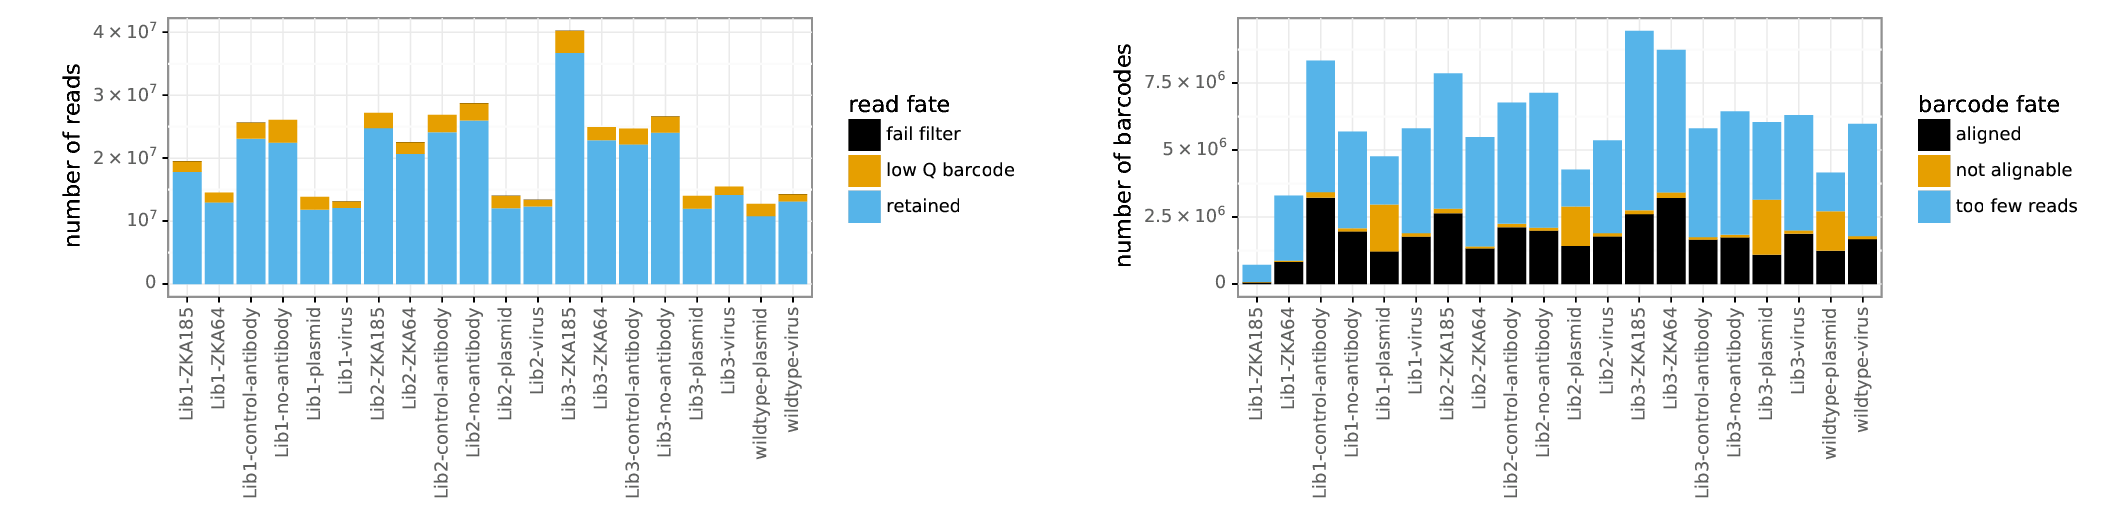

In [10]:
showPDF([bcsubamp_plot_prefix + 'readstats.pdf',
         bcsubamp_plot_prefix + 'bcstats.pdf'])

Next we look at number of reads per barcode.
In all samples except for the plasmid ones, we appear to have over-sequenced (or conversely, bottlenecked too much going from round 1 to round 2) as most barcodes are sequenced > 2 times except for singletons that probably represent sequencing errors. 
This problem is especially sever for *Lib1-ZKA185*, which is probably why we have so few barcodes for this sample.
This does mean that the sequences for the barcodes we did get will be highly reliable, however:

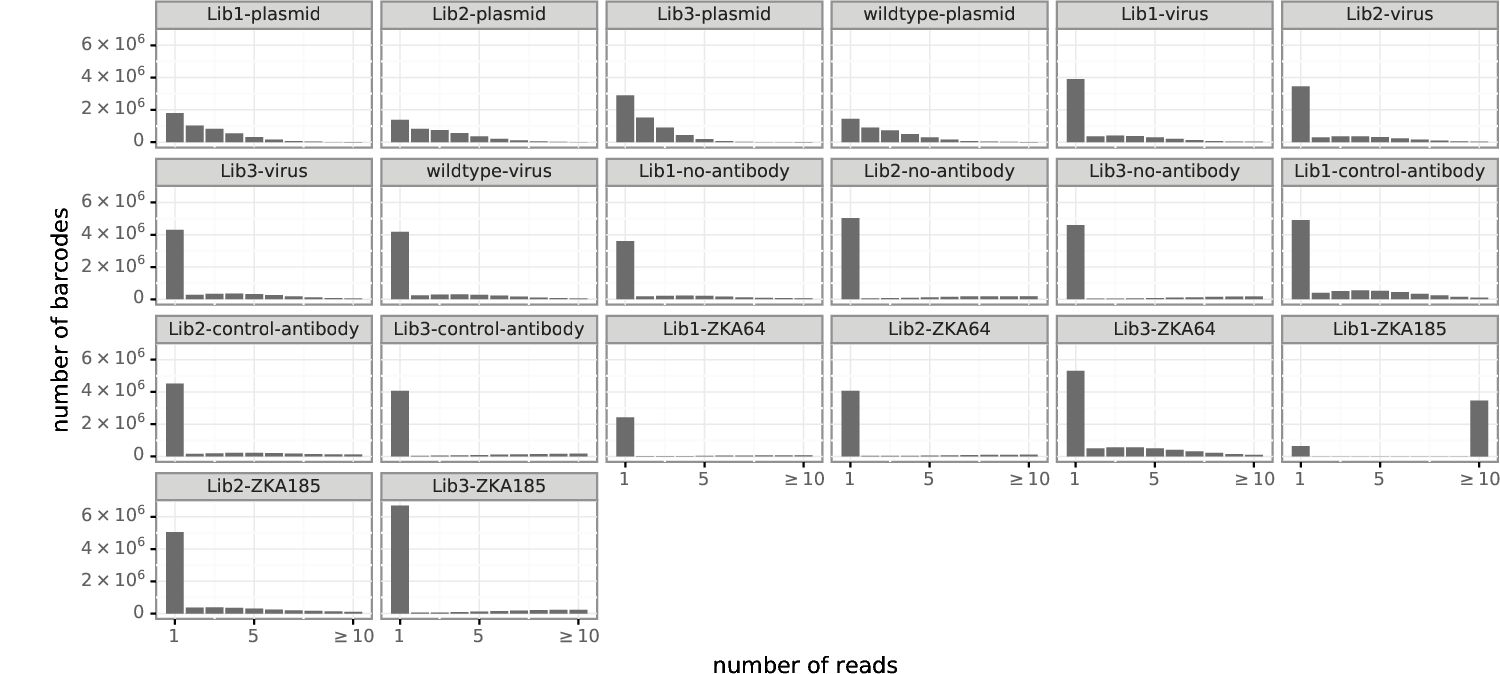

In [11]:
showPDF(bcsubamp_plot_prefix + 'readsperbc.pdf')

Now we look at the depth across the gene.
Except for *Lib1-ZKA185*, the depth seems sufficient for all samples.
There is some unneveness in the depth on the plasmid:

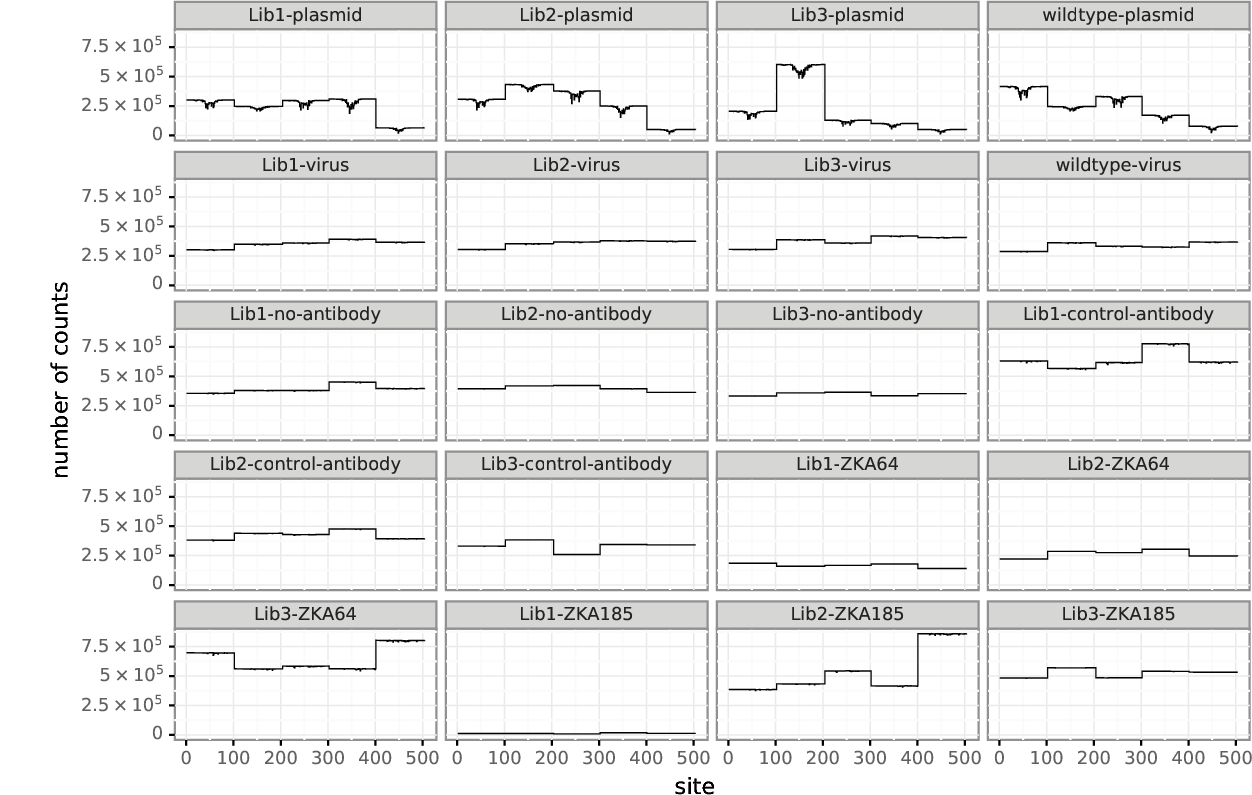

In [12]:
showPDF(bcsubamp_plot_prefix + 'depth.pdf')

Here are the mutation frequencies across the gene.
As expected, there are big peaks in the antibody selected samples, probably because the antibodies selected mutations.
We'll have to wait until more detailed analyses below to tell if these peaks make sense as being escape mutations.

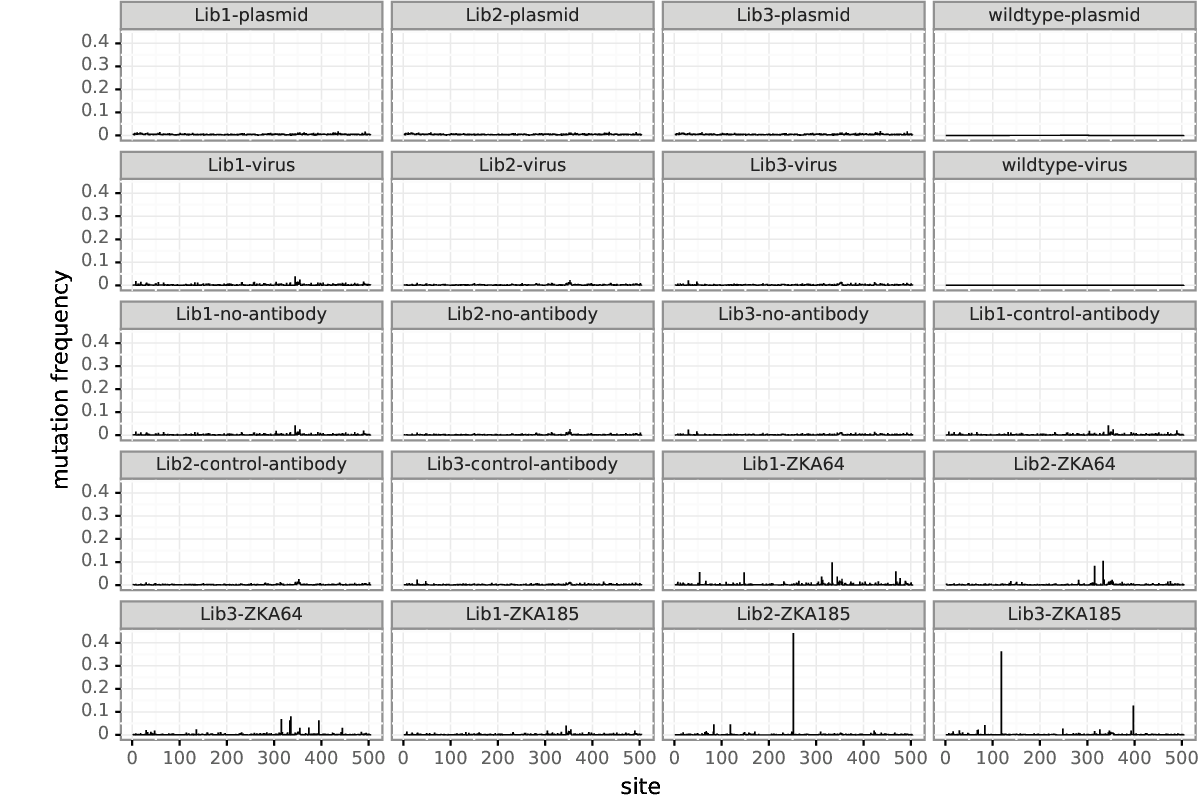

In [13]:
showPDF(bcsubamp_plot_prefix + 'mutfreq.pdf')

We also see that as expected, we get strong selection against stop codons in all samples except the unselected input plasmid library:

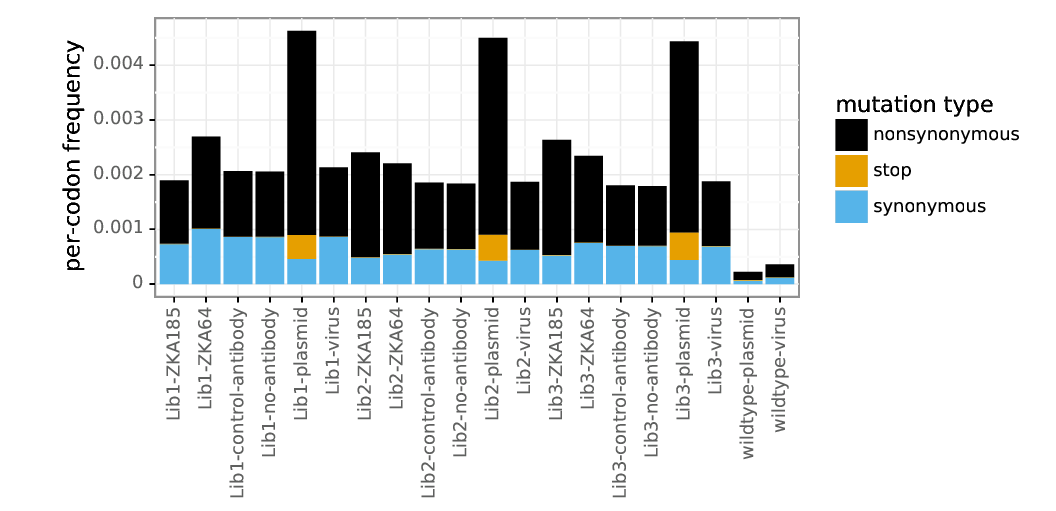

In [14]:
showPDF(bcsubamp_plot_prefix + 'codonmuttypes.pdf')

We have single and multi-nucleotide changes in the libraries, although the single nucleotide changes are perhaps over-represented:

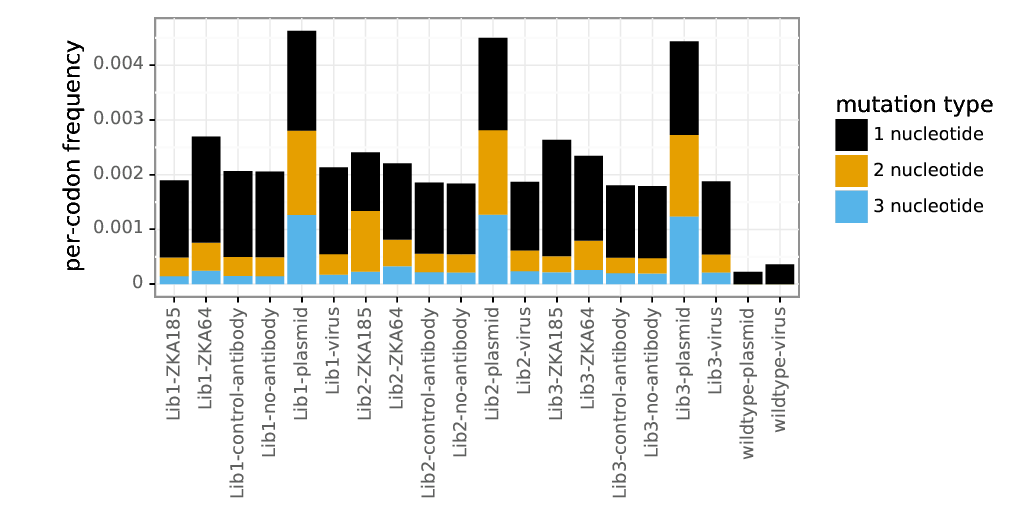

In [15]:
showPDF(bcsubamp_plot_prefix + 'codonntchanges.pdf')

Here are the frequencies of different types of mutations among single-nucleotide codon changes.
We see that unfortunately there does appear to be some oxidative damage to the plasmid samples, but it is not too bad.

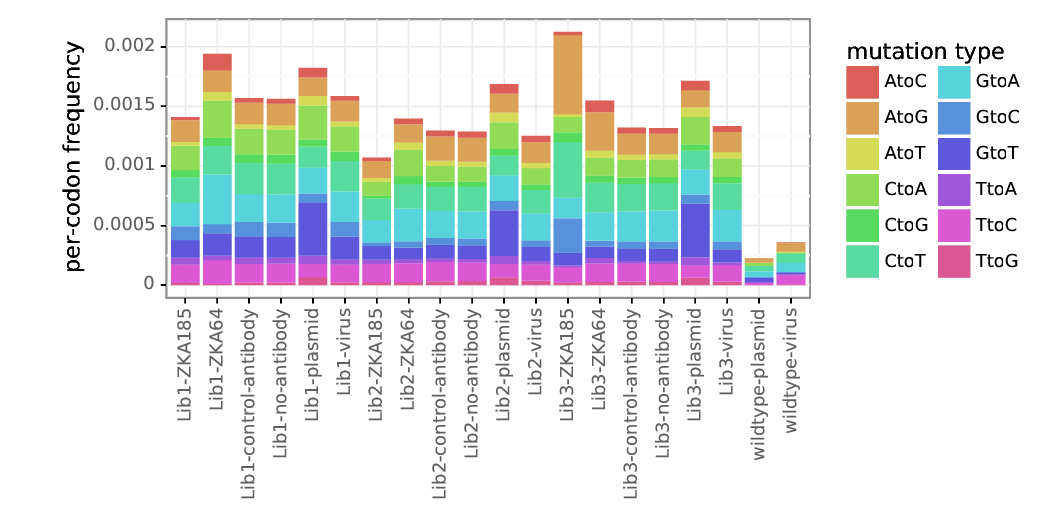

In [16]:
showPDF(bcsubamp_plot_prefix + 'singlentchanges.pdf')

Finally, we look at mutation sampling.
We can see that all possible mutations are sampled very well in the plasmid samples, and that mutation frequencies decrease a lot (as expected due to selection) in the other samples.

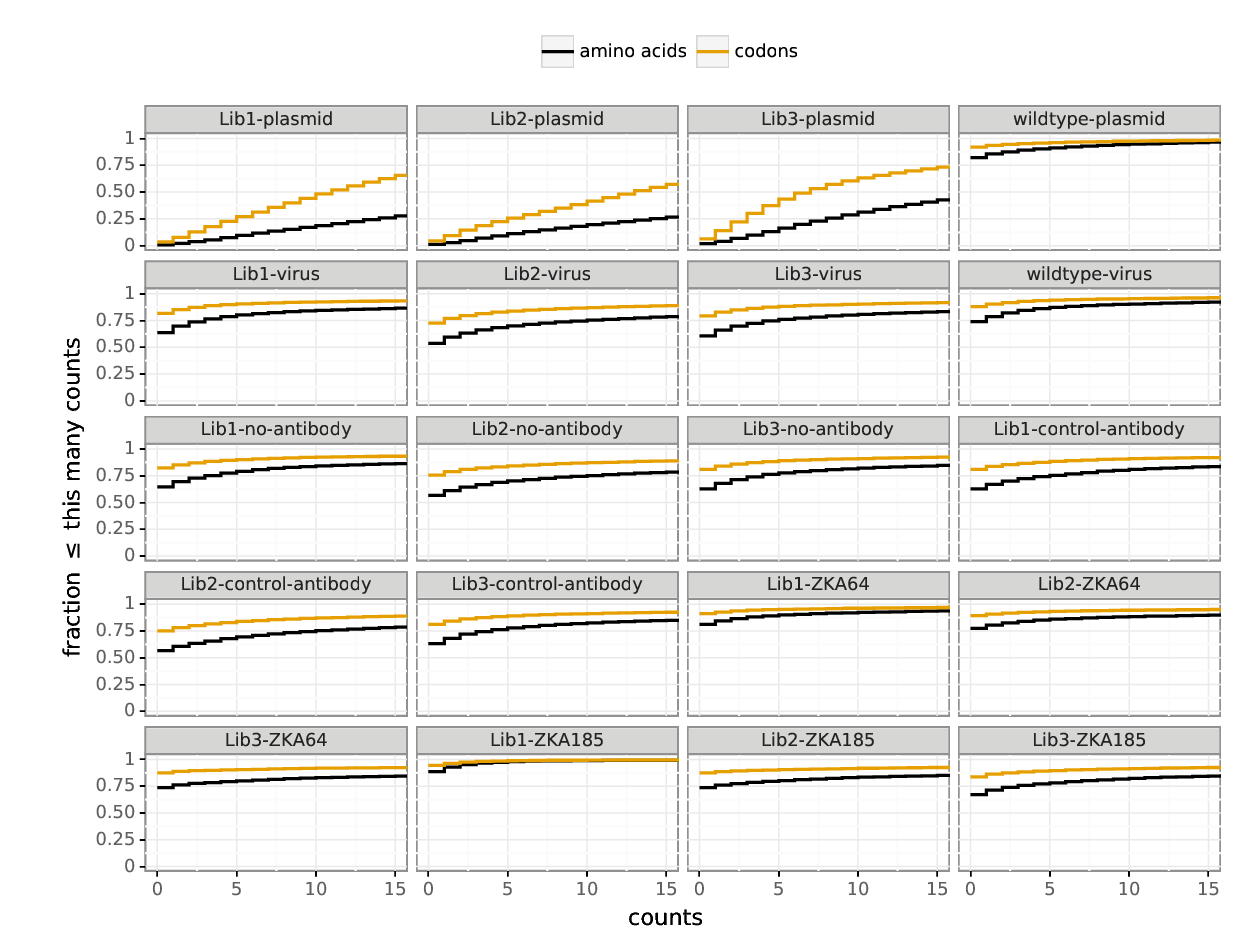

In [17]:
showPDF(bcsubamp_plot_prefix + 'cumulmutcounts.pdf')

## Amino-acid preferences under functional selection
Now we compute the amino-acid preferences under functional selection for viral growth.
To do this, we compare the passaged *virus* samples to the original *plasmid* samples, using the wildtype *plasmid* and *virus* samples as controls to estimate the error rates.
We run the analysis using [dms2_batch_prefs](https://jbloomlab.github.io/dms_tools2/dms2_batch_prefs.html).

First, construct the data frame with the batch file:

In [18]:
prefs_batch = collections.defaultdict(list)

for lib in samples.library.unique():
    if lib != 'wildtype':
        prefs_batch['name'].append(lib)
        prefs_batch['pre'].append(f'{lib}-plasmid')
        prefs_batch['post'].append(f'{lib}-virus')
        prefs_batch['errpre'].append('wildtype-plasmid')
        prefs_batch['errpost'].append('wildtype-virus')
        
prefs_batch = pandas.DataFrame(prefs_batch)

display(HTML(prefs_batch.to_html(index=False)))

name,pre,post,errpre,errpost
Lib1,Lib1-plasmid,Lib1-virus,wildtype-plasmid,wildtype-virus
Lib2,Lib2-plasmid,Lib2-virus,wildtype-plasmid,wildtype-virus
Lib3,Lib3-plasmid,Lib3-virus,wildtype-plasmid,wildtype-virus


Now run [dms2_batch_prefs](https://jbloomlab.github.io/dms_tools2/dms2_batch_prefs.html):

In [19]:
prefsdir = os.path.join(resultsdir, 'prefs')
os.makedirs(prefsdir, exist_ok=True)

prefs_batchfile = os.path.join(prefsdir, 'batch.csv')
prefs_batch.to_csv(prefs_batchfile, index=False)

log = ! dms2_batch_prefs \
        --indir {countsdir} \
        --batchfile {prefs_batchfile} \
        --outdir {prefsdir} \
        --summaryprefix summary \
        --use_existing {use_existing}

assert all(map(os.path.isfile, [os.path.join(prefsdir, lib + '_prefs.csv') 
                                for lib in prefs_batch.name]))

print("Amino-acid preferences calculated for all libraries.")

Amino-acid preferences calculated for all libraries.


Look at the correlation among the amino-acid preferences calculated for the individual libraries:

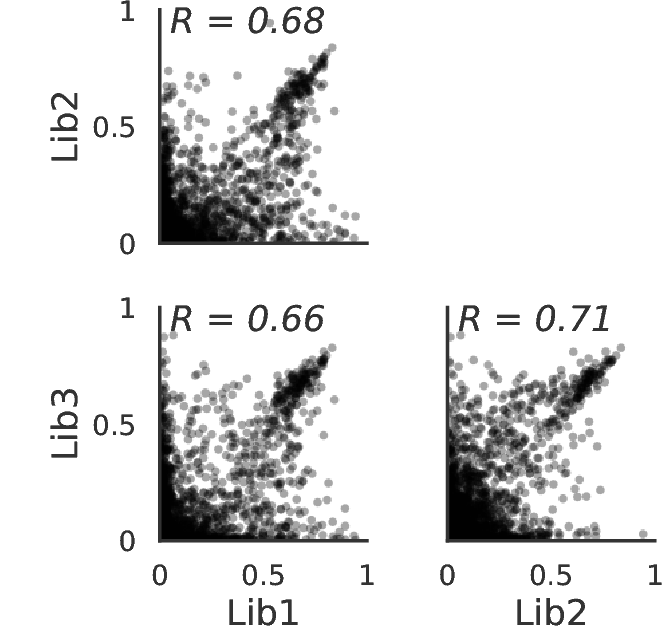

In [20]:
showPDF(os.path.join(prefsdir, 'summary_prefscorr.pdf'))

Now we will make a logo plot of the average of the amino-acid preferences across the libraries.
We do this using [dms2_logoplot](https://jbloomlab.github.io/dms_tools2/dms2_logoplot.html).
Note that this logo plot shows the raw unscaled (**not** re-scaled) preferences:

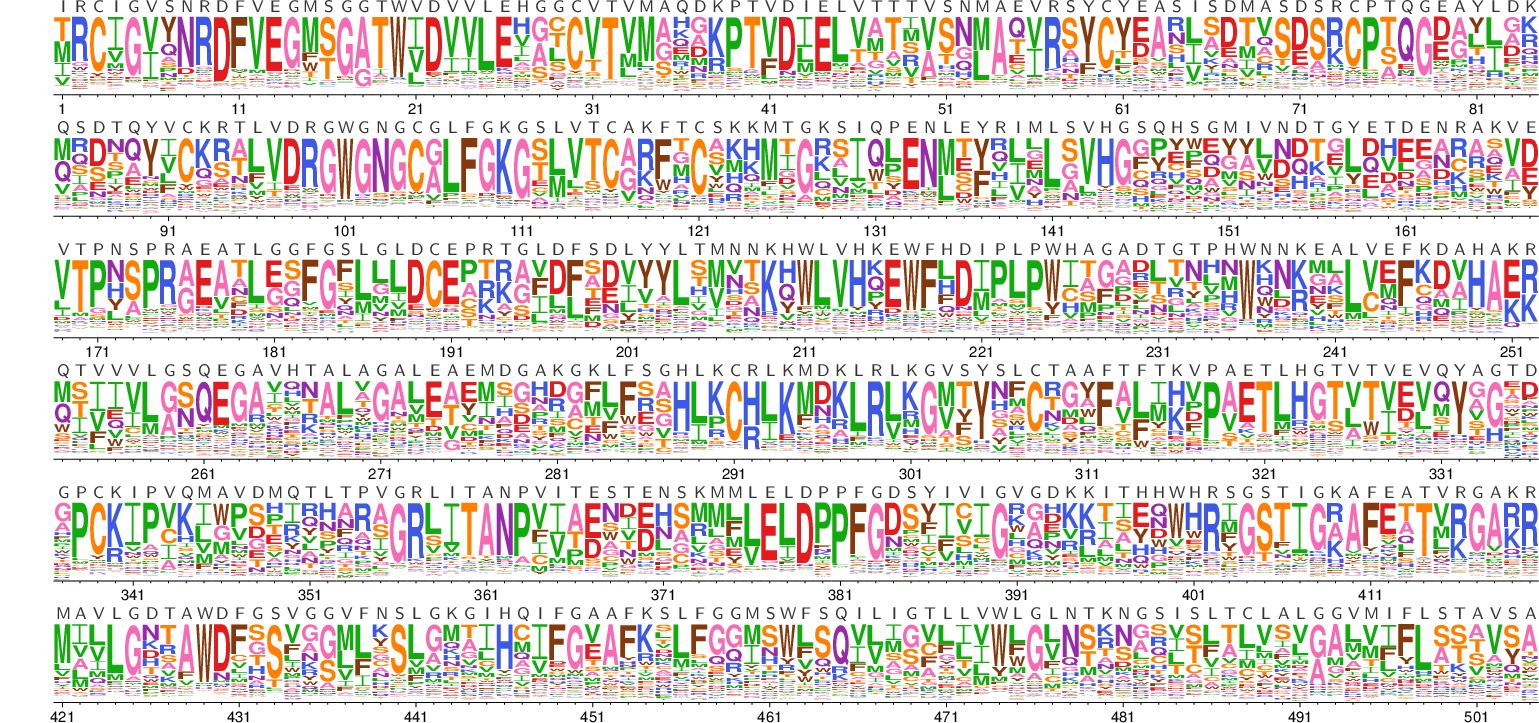

In [21]:
logodir = os.path.join(resultsdir, 'logoplots')
os.makedirs(logodir, exist_ok=True)

# more sensibly named file with unscaled average prefs
unscaledprefsfile = os.path.join(prefsdir, 'unscaled_prefs.csv')
! cp {os.path.join(prefsdir, 'summary_avgprefs.csv')} {unscaledprefsfile}

# read unscaled prefs into data frame for use later
unscaledprefs = pandas.read_csv(unscaledprefsfile)

# get wildtype amino acids to use as overlay
wt_aas = pandas.DataFrame.from_records(
            [(r + 1, a) for r, a in enumerate(refprot)],
            columns=['site', 'wildtype'])
wtoverlayfile = os.path.join(logodir, 'wt_overlay.csv')
wt_aas.to_csv(wtoverlayfile, index=False)

log = ! dms2_logoplot \
        --prefs {unscaledprefsfile} \
        --name unscaled \
        --outdir {logodir} \
        --nperline 84 \
        --overlay1 {wtoverlayfile} wildtype wildtype \
        --use_existing {use_existing}

showPDF(os.path.join(logodir, 'unscaled_prefs.pdf'))

## Mutational effects
We can also represent the effects of mutations in a different way than the amino acid preferences.
Specifically, the ratio of the preference for the mutant amino-acid to the wildtype amino-acid is a measure of its enrichment (this is just the ratio of letter heights in the plot above).
If we take the log of this mutational effect, negative values indicate deleterious mutations and positive values indicate favorable mutations.
The potential advantage of this representation is that it better shows the detailed differences between mutations to amino acids with small preferences, which can be useful for figuring out if we think a mutation is just very mildly deleterious or highly deleterious.
Note that for this calculation, the stringency re-scaling done below has no effect other than a change of units (y-axis scale), since the stringency parameter is just a constant multiplying the log mutational effects.

Here we calculate the mutational effects and then plot their log2 values on a logo plot.

First, create a subdirectory for these analyses:

In [22]:
muteffectsdir = os.path.join(resultsdir, 'muteffects/')
os.makedirs(muteffectsdir, exist_ok=True)

Convert the unscaled preferences into mutational effects:

In [23]:
muteffects = dms_tools2.prefs.prefsToMutFromWtEffects(
                prefs=unscaledprefs,
                charlist=AAS,
                wts=wt_aas)

The mutation effects indicate the relative ratio of the mutant to wildtype pre- and post-selection as calculated from the preferences, and the log2 of this value.
Here are the first few values:

In [24]:
display(HTML(muteffects.head().to_html(index=False)))

site,wildtype,mutant,mutation,effect,log2effect
1,I,A,I1A,0.030269,-5.046030
1,I,C,I1C,0.050461,-4.308696
1,I,D,I1D,0.067708,-3.884530
1,I,E,I1E,0.051099,-4.290569
1,I,F,I1F,0.048360,-4.370049


We write all of these mutation effects to a file:

In [25]:
muteffectsfile = os.path.join(muteffectsdir, 'unscaled_muteffects.csv')
muteffects.to_csv(muteffectsfile, index=False)

Now make a logo plot showing the mutational effects.
Letters below the line indicate deleterious mutations, and letters above the line indicate beneficial ones.
We include a scale bar indicating the fold-enrichment implied by each letter height:

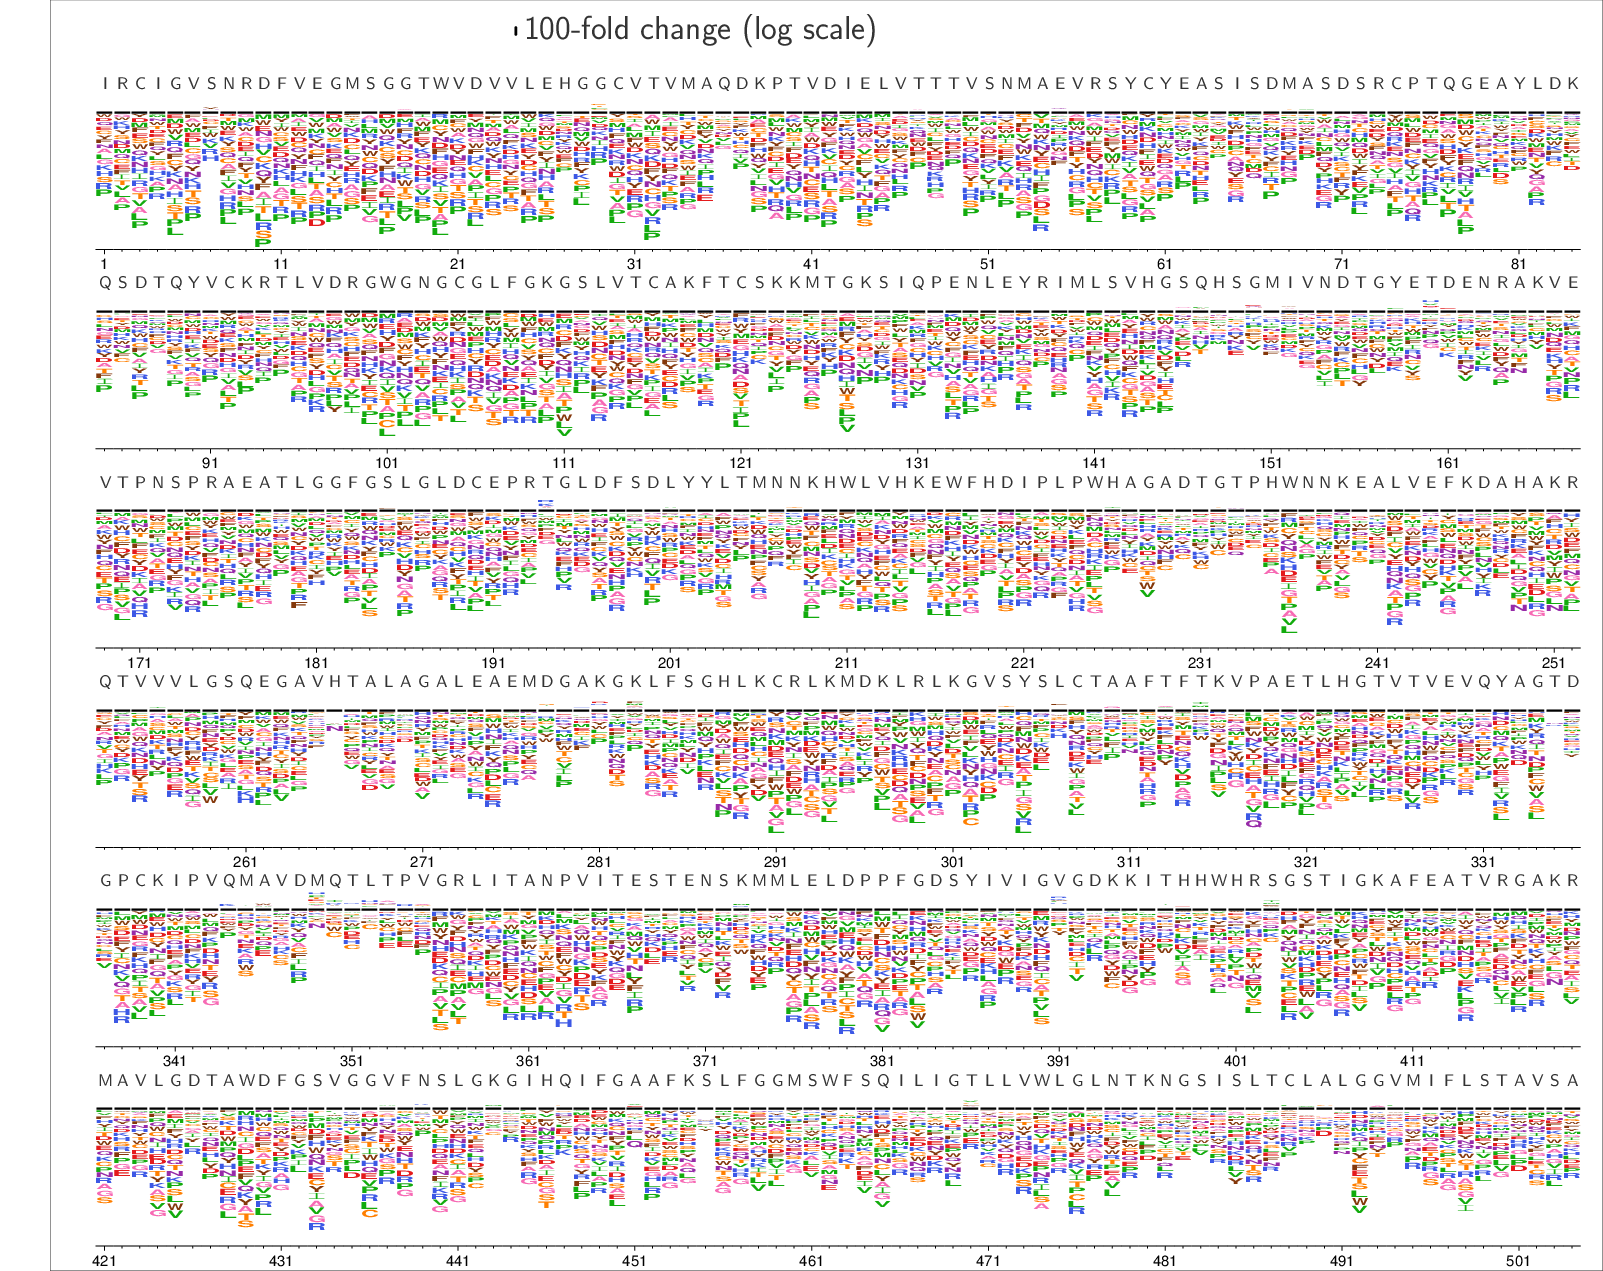

In [26]:
log = ! dms2_logoplot \
        --muteffects {muteffectsfile} \
        --name unscaled \
        --outdir {logodir} \
        --nperline 84 \
        --overlay1 {wtoverlayfile} wildtype wildtype \
        --scalebar 6.64 "100-fold change (log scale)" \
        --use_existing {use_existing}

showPDF(os.path.join(logodir, 'unscaled_muteffects.pdf'))

## Phylogenetic analyses with experimentally informed codon models
Now we perform phylogenetic analyses with experimentally informed codon models (ExpCM) that use the deep mutational scanning data (see [here](https://peerj.com/articles/3657/) for background on ExpCMs).

Set up directory for these analyses:

In [27]:
phylodir = os.path.join(resultsdir, 'phylogenetics/')
os.makedirs(phylodir, exist_ok=True)

We have a manually curated alignment of Zika virus E protein coding sequences in [./data/E_alignment.fasta](data/E_alignment.fasta):

In [28]:
alignment_file = './data/E_alignment.fasta'

alignment = list(Bio.SeqIO.parse(alignment_file, 'fasta'))
print(f"There are {len(alignment)} sequences in {alignment_file}")

There are 78 sequences in ./data/E_alignment.fasta


Now we run [phydms](http://jbloomlab.github.io/phydms/) (using the [phydms_comprehensive](http://jbloomlab.github.io/phydms/phydms_comprehensive_prog.html) program) to fit ExpCM and standard codon models to these sequences:

In [29]:
modelcomparisonfile = os.path.join(phylodir, 'phydms_modelcomparison.md')

if not os.path.isfile(modelcomparisonfile) or use_existing != 'yes':
    prefs_for_phydms = os.path.join(phylodir, 'prefs.csv')
    ! cp {unscaledprefsfile} {prefs_for_phydms}
    log = ! phydms_comprehensive \
            {os.path.join(phylodir, 'phydms')} \
            {alignment_file} \
            {prefs_for_phydms} \
            --raxml raxmlHPC \
            --ncpus {ncpus}
    assert os.path.isfile(modelcomparisonfile)

Let's visualize the phylogenetic tree.
The topology will be the same for the tree under any model, so let's look at it under the ExpCM.
We label tips by accession and country / year of isolation:

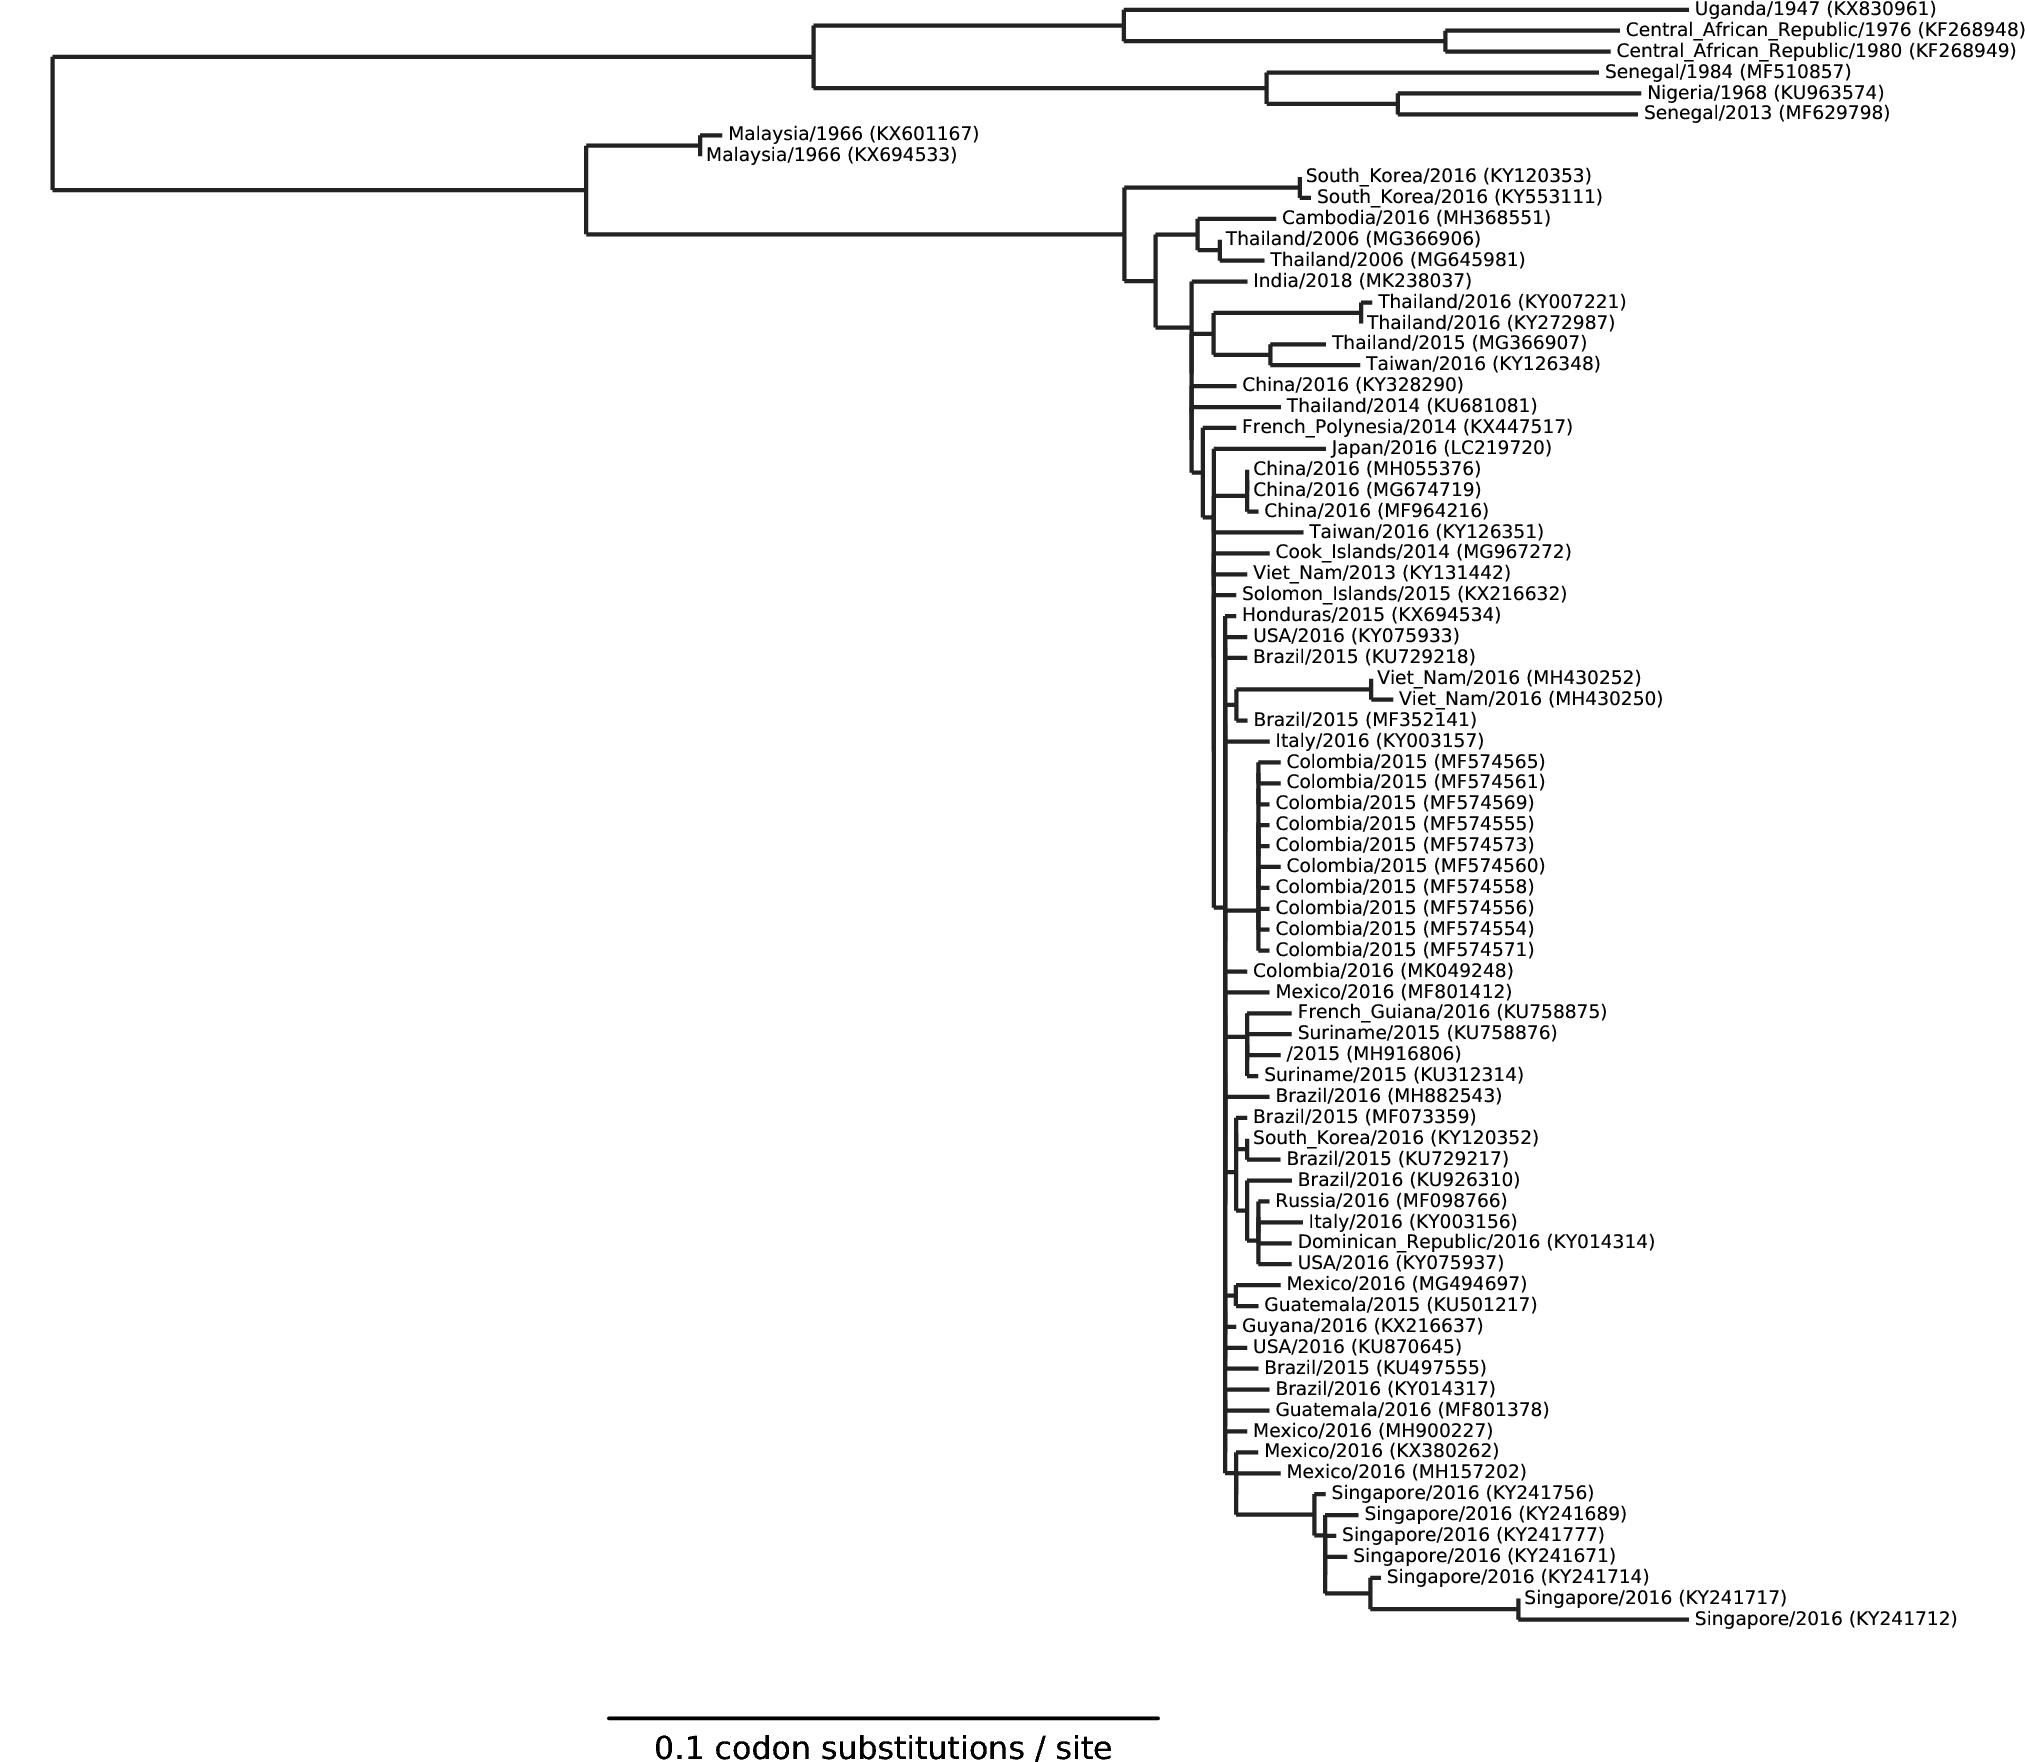

In [30]:
treefile = os.path.join(phylodir, 'phydms_ExpCM_prefs_tree.newick')

treefigfile = os.path.join(phylodir, 'tree.pdf')

# read tree
tree = Bio.Phylo.read(treefile, 'newick')
tree.root_at_midpoint()
    
# rename tips
for tip in tree.get_terminals():
    acc = tip.name.split('_')[0].split('|')[0]
    loc = tip.name.split('|')[1]
    year = tip.name.split('|')[2].split('/')[0]
    tip.name = f"{loc}/{year} ({acc})"

# plot and format tree
Bio.Phylo.draw(tree,
               do_show=False)
treefig = plt.gcf()
treefig.set_size_inches(17, 14)
ax = treefig.axes[0]
ax.axis('off')

# add scale bar
(x0, x1, y0, y1) = plt.axis()
xstart = x0 + 0.3 * (x1 - x0)
barlen = 0.1
yline = y0 - 0.05 * (y1 - y0)
ytext = yline - 0.01 * (y1 - y0)
ax.set_ylim(ytext, y1)
plt.plot([xstart, xstart + barlen], [yline, yline], color='black', 
         linestyle='-', linewidth=2)
plt.text(xstart + barlen / 2., ytext, 
         f'{barlen} codon substitutions / site',
         horizontalalignment='center',
         verticalalignment='top',
         color='black',
         fontsize=17)

treefig.tight_layout()
treefig.savefig(treefigfile)
plt.close()

showPDF(treefigfile)

Now let's look at the result of the phylogenetic model comparison from the analysis.
We see below that the ExpCM is the best model by far:

In [31]:
# read model comparison to dataframe for gamma-omega models
modelcompare = (phydmslib.utils.modelComparisonDataFrame(
                modelcomparisonfile, splitparams=True)
        .assign(avgomega=lambda x: x.alpha_omega / x.beta_omega)
        [['Model', 'deltaAIC', 'LogLikelihood', 'nParams', 'beta', 
          'omega', 'avgomega', 'alpha_omega', 'beta_omega']]
        .rename(columns={'beta':'stringency', 'deltaAIC':'$\Delta$AIC',
                'avgomega':'$\overline{\omega}$', 'kappa':'$\kappa$', 
                'alpha_omega':'$\omega_{\\alpha}$', 
                'beta_omega':'$\omega_{\\beta}$',
                'omega':'$\omega$'})
        )

display(HTML(modelcompare.to_html(index=False)))

Model,$\Delta$AIC,LogLikelihood,nParams,stringency,$\omega$,$\overline{\omega}$,$\omega_{\alpha}$,$\omega_{\beta}$
ExpCM_prefs,0.00,-4749.59,6,1.65,0.31,NaN,NaN,NaN
YNGKP_M5,2059.06,-5773.12,12,NaN,NaN,0.089806,0.37,4.12
averaged_ExpCM_prefs,2063.46,-5781.32,6,0.59,0.09,NaN,NaN,NaN
YNGKP_M0,2081.02,-5785.10,11,NaN,0.09,NaN,NaN,NaN


Extract the stringency parameter from the ExpCM to use to re-scale the preferences to better align with the strength of natural selection (see [here](https://peerj.com/articles/3657/)).
The fact that we have a stringency parameter > 1 means that natural selection favors the same amino acids in the experiment, but more stringently:

In [32]:
stringency = float(modelcompare.set_index('Model')['stringency'].to_dict()['ExpCM_prefs'])

print(f"Stringency parameter is {stringency}")

Stringency parameter is 1.65


Re-scale the preferences by this stringency parameter, add information on wildtype amino acids, and write to a file:

In [33]:
rescaledprefs = dms_tools2.prefs.rescalePrefs(unscaledprefs, stringency)

# add information about wildtype amino acid
unscaledprefs = (wt_aas
                 .merge(unscaledprefs)
                 .assign(labeledsite=lambda x: x.wildtype + x.site.astype('str'))
                 )
rescaledprefs = (wt_aas
                 .merge(rescaledprefs)
                 .assign(labeledsite=lambda x: x.wildtype + x.site.astype('str'))
                 )

# write rescaled prefs to file
rescaledprefsfile = os.path.join(prefsdir, 'rescaled_prefs.csv')
rescaledprefs.to_csv(rescaledprefsfile, index=False)
print(f"Re-scaled prefs written to {rescaledprefsfile}")

Re-scaled prefs written to ./results/prefs/rescaled_prefs.csv


Now make a logo plot of the **re-scaled** preferences:

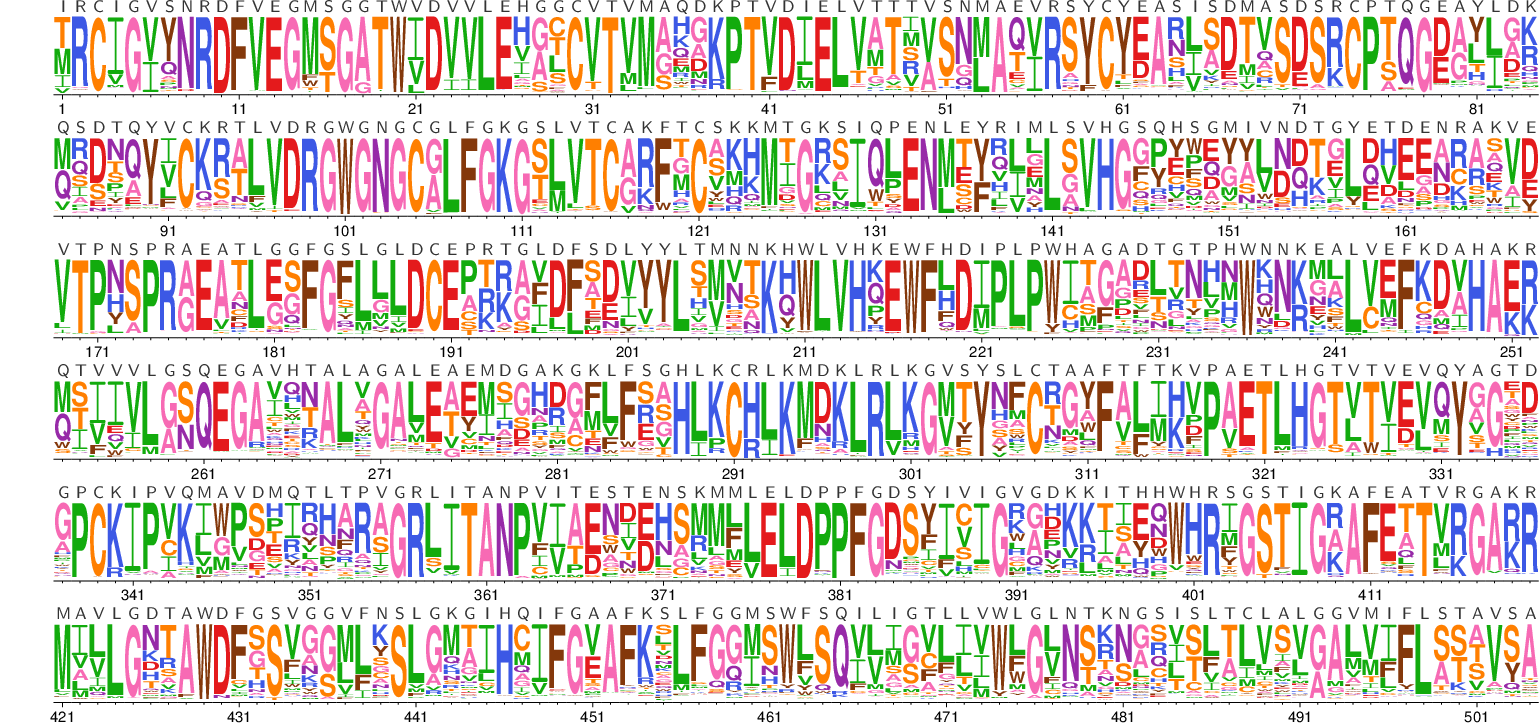

In [34]:
log = ! dms2_logoplot \
        --prefs {rescaledprefsfile} \
        --name rescaled \
        --outdir {logodir} \
        --nperline 84 \
        --overlay1 {wtoverlayfile} wildtype wildtype \
        --ignore_extracols yes \
        --use_existing {use_existing}

showPDF(os.path.join(logodir, 'rescaled_prefs.pdf'))

## Differential selection
We now compute the [differential selection](https://jbloomlab.github.io/dms_tools2/diffsel.html) from each antibody selection.
We do this using [dms2_batch_diffsel](https://jbloomlab.github.io/dms_tools2/dms2_batch_diffsel.html).

In [35]:
diffseldir = os.path.join(resultsdir, 'diffsel')
os.makedirs(diffseldir, exist_ok=True)

Now we create a batch file for running [dms2_batch_diffsel](https://jbloomlab.github.io/dms_tools2/dms2_batch_diffsel.html).
Note that we use the "no antibody" condition as our mock selection, and our wildtype virus as our error control:

In [36]:
diffsel_batch = (
    samples
    .assign(sel=lambda x: x['name'],
            mock=lambda x: x['library'] + '-no-antibody',
            err='wildtype-virus',
            libfracsurvive=lambda x:
                numpy.clip(x.percent_infectivity / 100, None, 1)
            )
    .query('antibody not in ["none", "no-antibody"]')
    .drop(columns=['name'])
    .rename(columns={'antibody':'group', 'library':'name'})
    [['group', 'name', 'sel', 'mock', 'err',
      'percent_infectivity', 'libfracsurvive']]
    .reset_index(drop=True)
    )

display(HTML(diffsel_batch.to_html(index=False)))

group,name,sel,mock,err,percent_infectivity,libfracsurvive
control-antibody,Lib1,Lib1-control-antibody,Lib1-no-antibody,wildtype-virus,104.65000,1.000000
control-antibody,Lib2,Lib2-control-antibody,Lib2-no-antibody,wildtype-virus,67.35000,0.673500
control-antibody,Lib3,Lib3-control-antibody,Lib3-no-antibody,wildtype-virus,80.14000,0.801400
ZKA64,Lib1,Lib1-ZKA64,Lib1-no-antibody,wildtype-virus,2.34000,0.023400
ZKA64,Lib2,Lib2-ZKA64,Lib2-no-antibody,wildtype-virus,1.54000,0.015400
ZKA64,Lib3,Lib3-ZKA64,Lib3-no-antibody,wildtype-virus,2.21000,0.022100
ZKA185,Lib1,Lib1-ZKA185,Lib1-no-antibody,wildtype-virus,0.00059,0.000006
ZKA185,Lib2,Lib2-ZKA185,Lib2-no-antibody,wildtype-virus,1.93000,0.019300
ZKA185,Lib3,Lib3-ZKA185,Lib3-no-antibody,wildtype-virus,1.39000,0.013900


We see that ZKA185 Lib1 has a **very low** percent infectivity, indicating that nearly all the library was neutralized.
Also, when we plotted the mutation frequency line plots above, this one looked different (no real signal).
Probably we just have noise when the neutralization is that strong, so we filter samples (i.e. ZKA185 Lib1) with percent infectivity less than 0.01%.

In [37]:
diffsel_batch = diffsel_batch.query('percent_infectivity > 0.01')

display(HTML(diffsel_batch.to_html(index=False)))

group,name,sel,mock,err,percent_infectivity,libfracsurvive
control-antibody,Lib1,Lib1-control-antibody,Lib1-no-antibody,wildtype-virus,104.65,1.0000
control-antibody,Lib2,Lib2-control-antibody,Lib2-no-antibody,wildtype-virus,67.35,0.6735
control-antibody,Lib3,Lib3-control-antibody,Lib3-no-antibody,wildtype-virus,80.14,0.8014
ZKA64,Lib1,Lib1-ZKA64,Lib1-no-antibody,wildtype-virus,2.34,0.0234
ZKA64,Lib2,Lib2-ZKA64,Lib2-no-antibody,wildtype-virus,1.54,0.0154
ZKA64,Lib3,Lib3-ZKA64,Lib3-no-antibody,wildtype-virus,2.21,0.0221
ZKA185,Lib2,Lib2-ZKA185,Lib2-no-antibody,wildtype-virus,1.93,0.0193
ZKA185,Lib3,Lib3-ZKA185,Lib3-no-antibody,wildtype-virus,1.39,0.0139


Write to the batch file: 

In [38]:
diffsel_batchfile = os.path.join(diffseldir, 'batch.csv')
diffsel_batch.to_csv(diffsel_batchfile, index=False)

Now run [dms2_batch_diffsel](https://jbloomlab.github.io/dms_tools2/dms2_batch_diffsel.html):

In [39]:
log = ! dms2_batch_diffsel \
        --batchfile {diffsel_batchfile} \
        --summaryprefix summary \
        --indir {countsdir} \
        --outdir {diffseldir} \
        --ncpus {ncpus} \
        --use_existing {use_existing}

Now let's look at the plots summarizing the results.

First, we examine the correlation between replicates. 
We do this for the positive site differential selection, in our prior work (e.g., [Doud et al (2017)](https://journals.plos.org/plospathogens/article?id=10.1371/journal.ppat.1006271) and [Dingens et al (2017)](https://www.sciencedirect.com/science/article/pii/S1931312817301968?via%3Dihub)), this has been the most useful differential selection statistic.
The plots below show fairly good correlations for the two anti-Zika virus antibodies, but much less correlation for the control antibody.
This is expected since the control antibody experiment is probably mostly noise and has much lower overall differential selection:

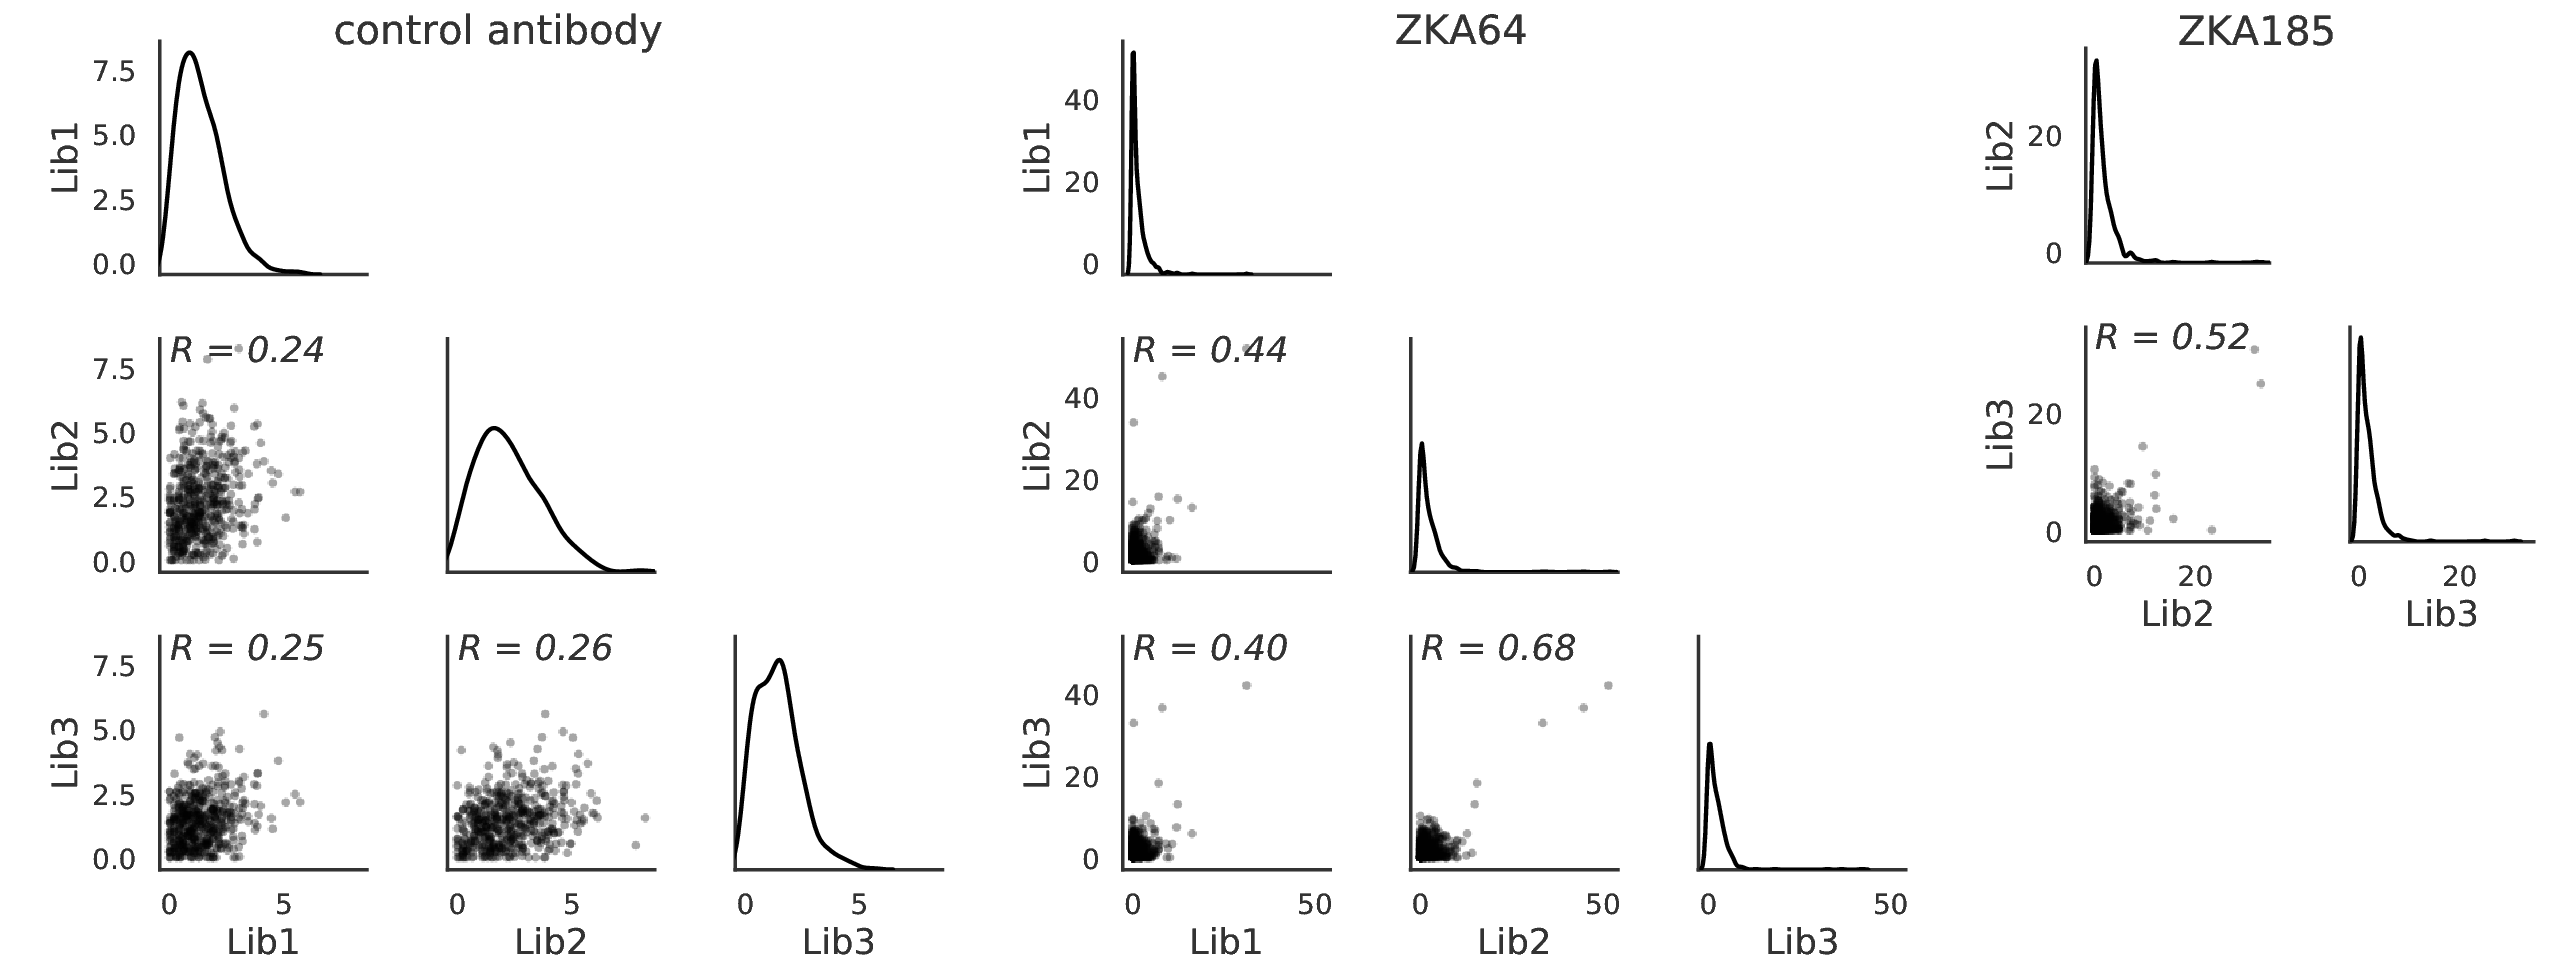

In [40]:
showPDF([os.path.join(diffseldir, f'summary_{antibody}-positivesitediffselcorr.pdf')
         for antibody in diffsel_batch['group'].unique()])

Now we look at the positive differential selection for each antibody, taking the mean across the replicates.
We see clear peaks of differentially selected sites for both antibodies, but no peaks for the control antibody:

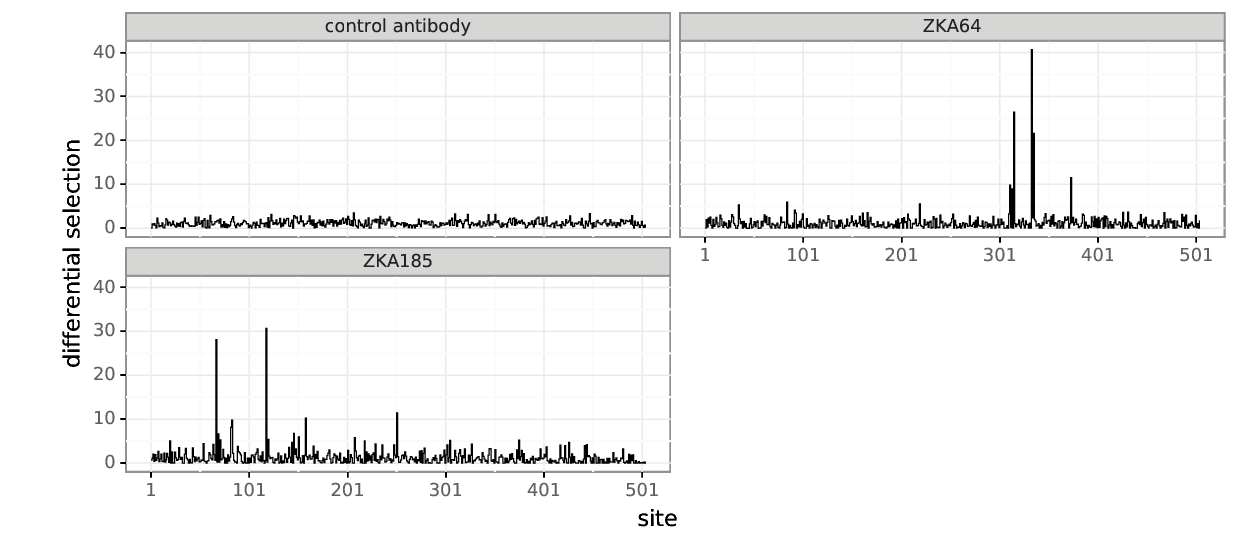

In [41]:
showPDF(os.path.join(diffseldir, 'summary_meanpositivediffsel.pdf'))

We also look at the total differential selection, including **negative** differential selection.
So far in all our work, we have never determined if this negative differential selection is meaningful.
Still, we plot it in case it actually indicates sites where mutations increase neutralization sensitivity (it might also be spurious signal):

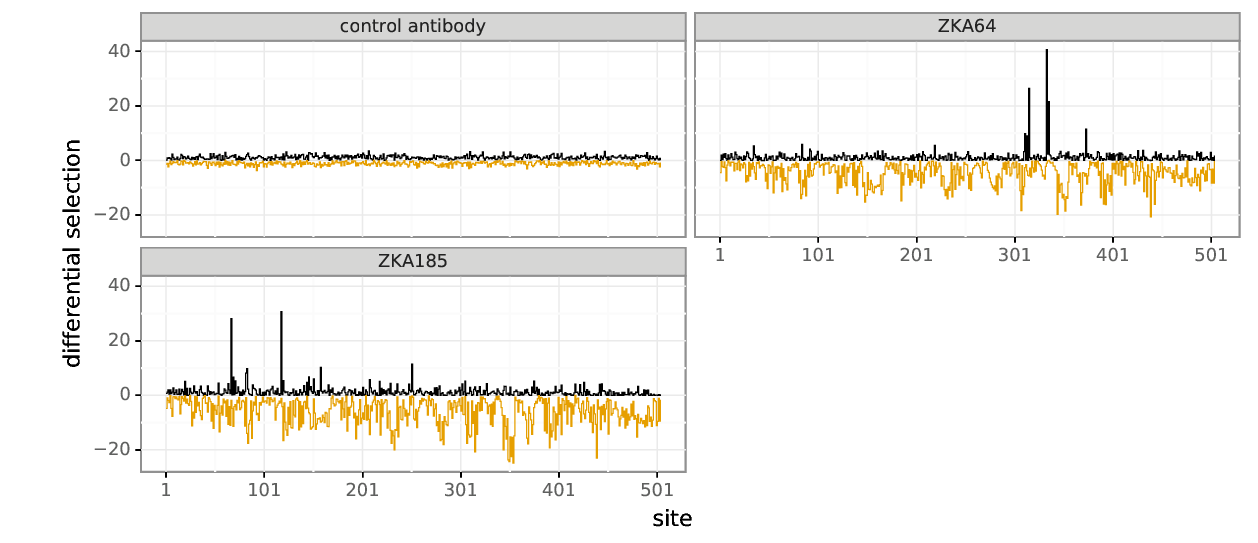

In [42]:
showPDF(os.path.join(diffseldir, 'summary_meantotaldiffsel.pdf'))

Finally, we use [dms2_logoplot](https://jbloomlab.github.io/dms_tools2/dms2_logoplot.html) to make a logo plot of the across-replicate mean **positive** (note use of `--restrictdiffsel positive`) differential selection for each non-control antibody:



Diffsel for ZKA64 (plot saved to ./results/logoplots/ZKA64_diffsel.pdf):


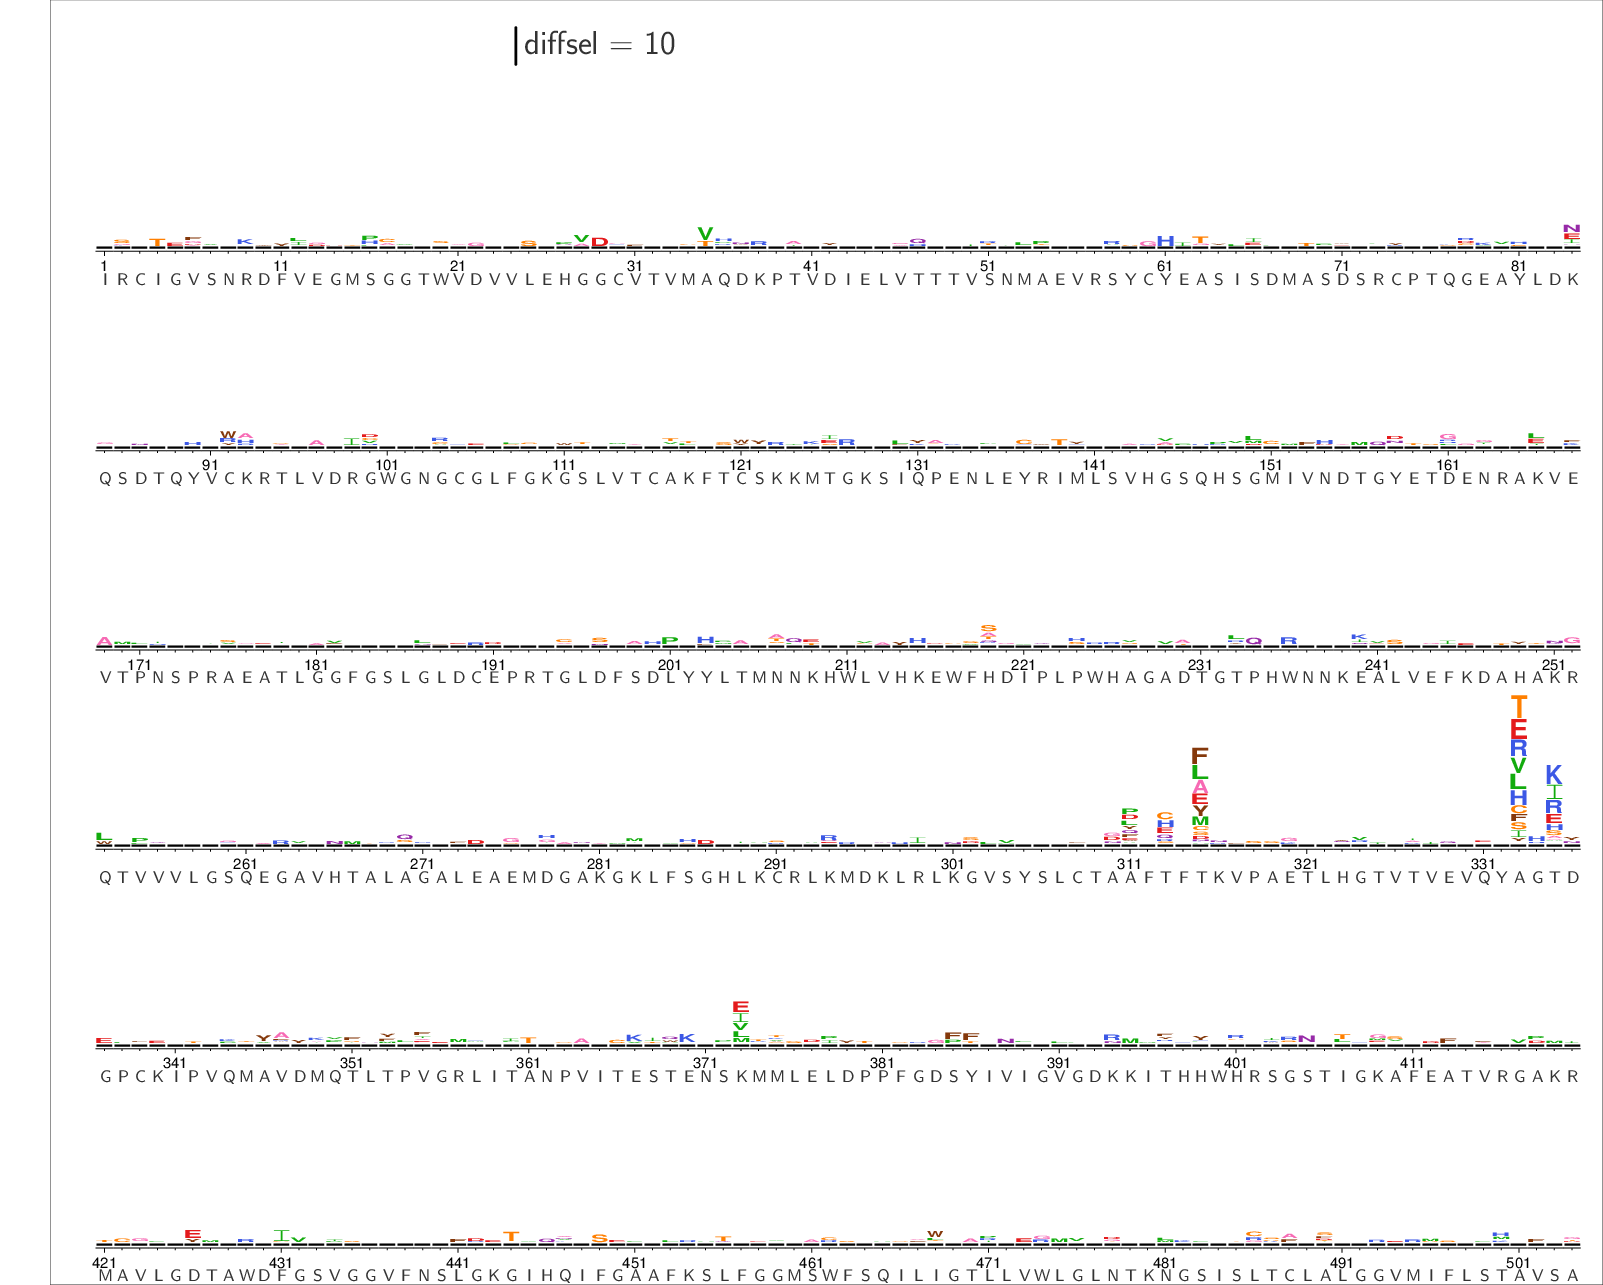



Diffsel for ZKA185 (plot saved to ./results/logoplots/ZKA185_diffsel.pdf):


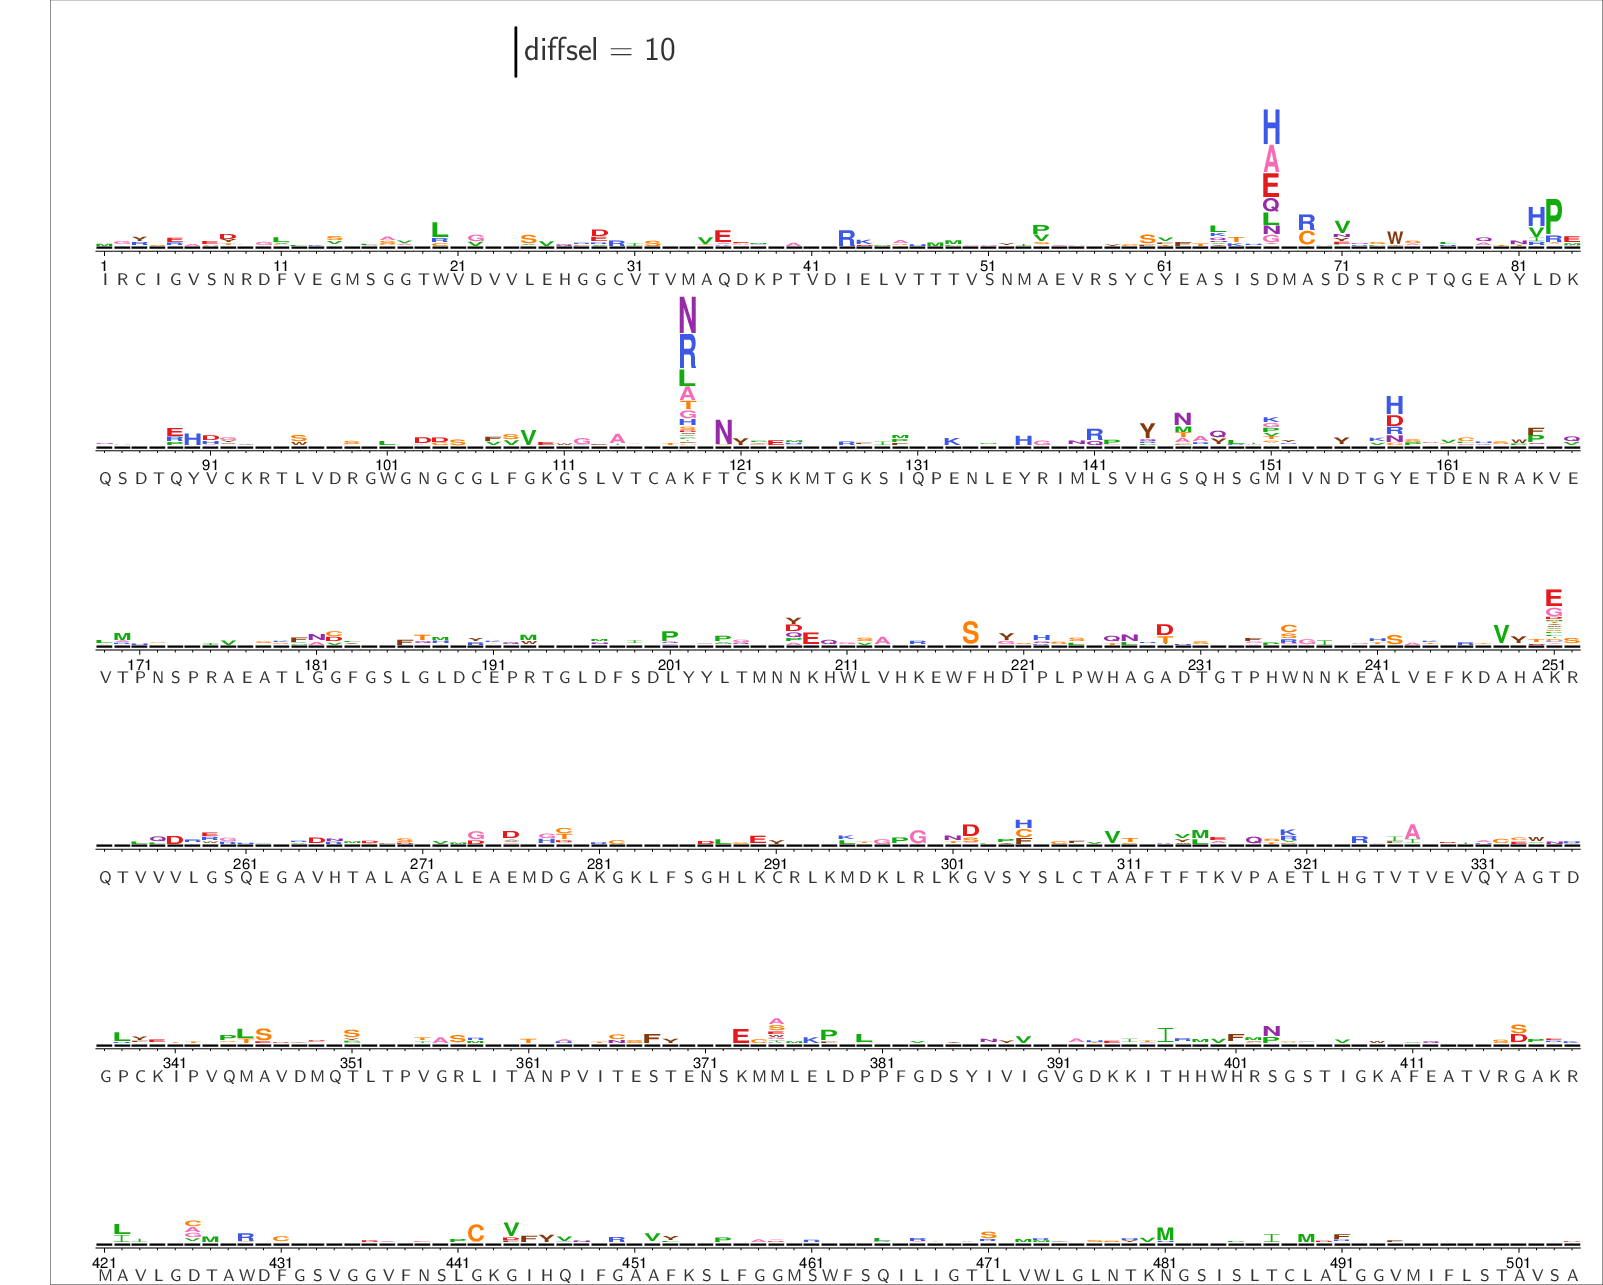

In [43]:
for antibody in diffsel_batch.query('group != "control-antibody"').group.unique():
    logoplot = os.path.join(logodir, f"{antibody}_diffsel.pdf")
    diffselfile = os.path.join(diffseldir,
                               f'summary_{antibody}-meanmutdiffsel.csv')
    print(f"\n\nDiffsel for {antibody} (plot saved to {logoplot}):")
    log = ! dms2_logoplot \
        --outdir {logodir} \
        --name {antibody} \
        --diffsel {diffselfile} \
        --restrictdiffsel positive \
        --nperline 84 \
        --overlay1 {wtoverlayfile} wildtype wildtype \
        --scalebar 10 "diffsel = 10" \
        --underlay yes \
        --use_existing no
    showPDF(logoplot)

## Fraction surviving
A second way to look at sites of antibody selection is to calculate the [fraction surviving](https://jbloomlab.github.io/dms_tools2/fracsurvive.html) for virions with each mutations.

Here we do this, using the [dms2_batch_fracsurvive](https://jbloomlab.github.io/dms_tools2/dms2_batch_fracsurvive.html) program.
Note that we calculate the **excess** fraction surviving (or fraction surviving above average) by using the `--aboveavg yes` flag.

First, we write the batch file for [dms2_batch_fracsurvive](https://jbloomlab.github.io/dms_tools2/dms2_batch_fracsurvive.html), which can be the same one we used for differential selection above:

In [44]:
fracsurvivedir = os.path.join(resultsdir, 'fracsurvive')
os.makedirs(fracsurvivedir, exist_ok=True)

fracsurvive_batchfile = os.path.join(fracsurvivedir, 'batch.csv')
diffsel_batch.to_csv(fracsurvive_batchfile, index=False)

Now run [dms2_batch_fracsurvive](https://jbloomlab.github.io/dms_tools2/dms2_batch_fracsurvive.html) (note the use of the `--aboveavg yes` flag): 

In [45]:
log = ! dms2_batch_fracsurvive \
        --batchfile {fracsurvive_batchfile} \
        --summaryprefix summary \
        --aboveavg yes \
        --indir {countsdir} \
        --outdir {fracsurvivedir} \
        --ncpus {ncpus} \
        --use_existing {use_existing}

Here are the correlations among replicates:

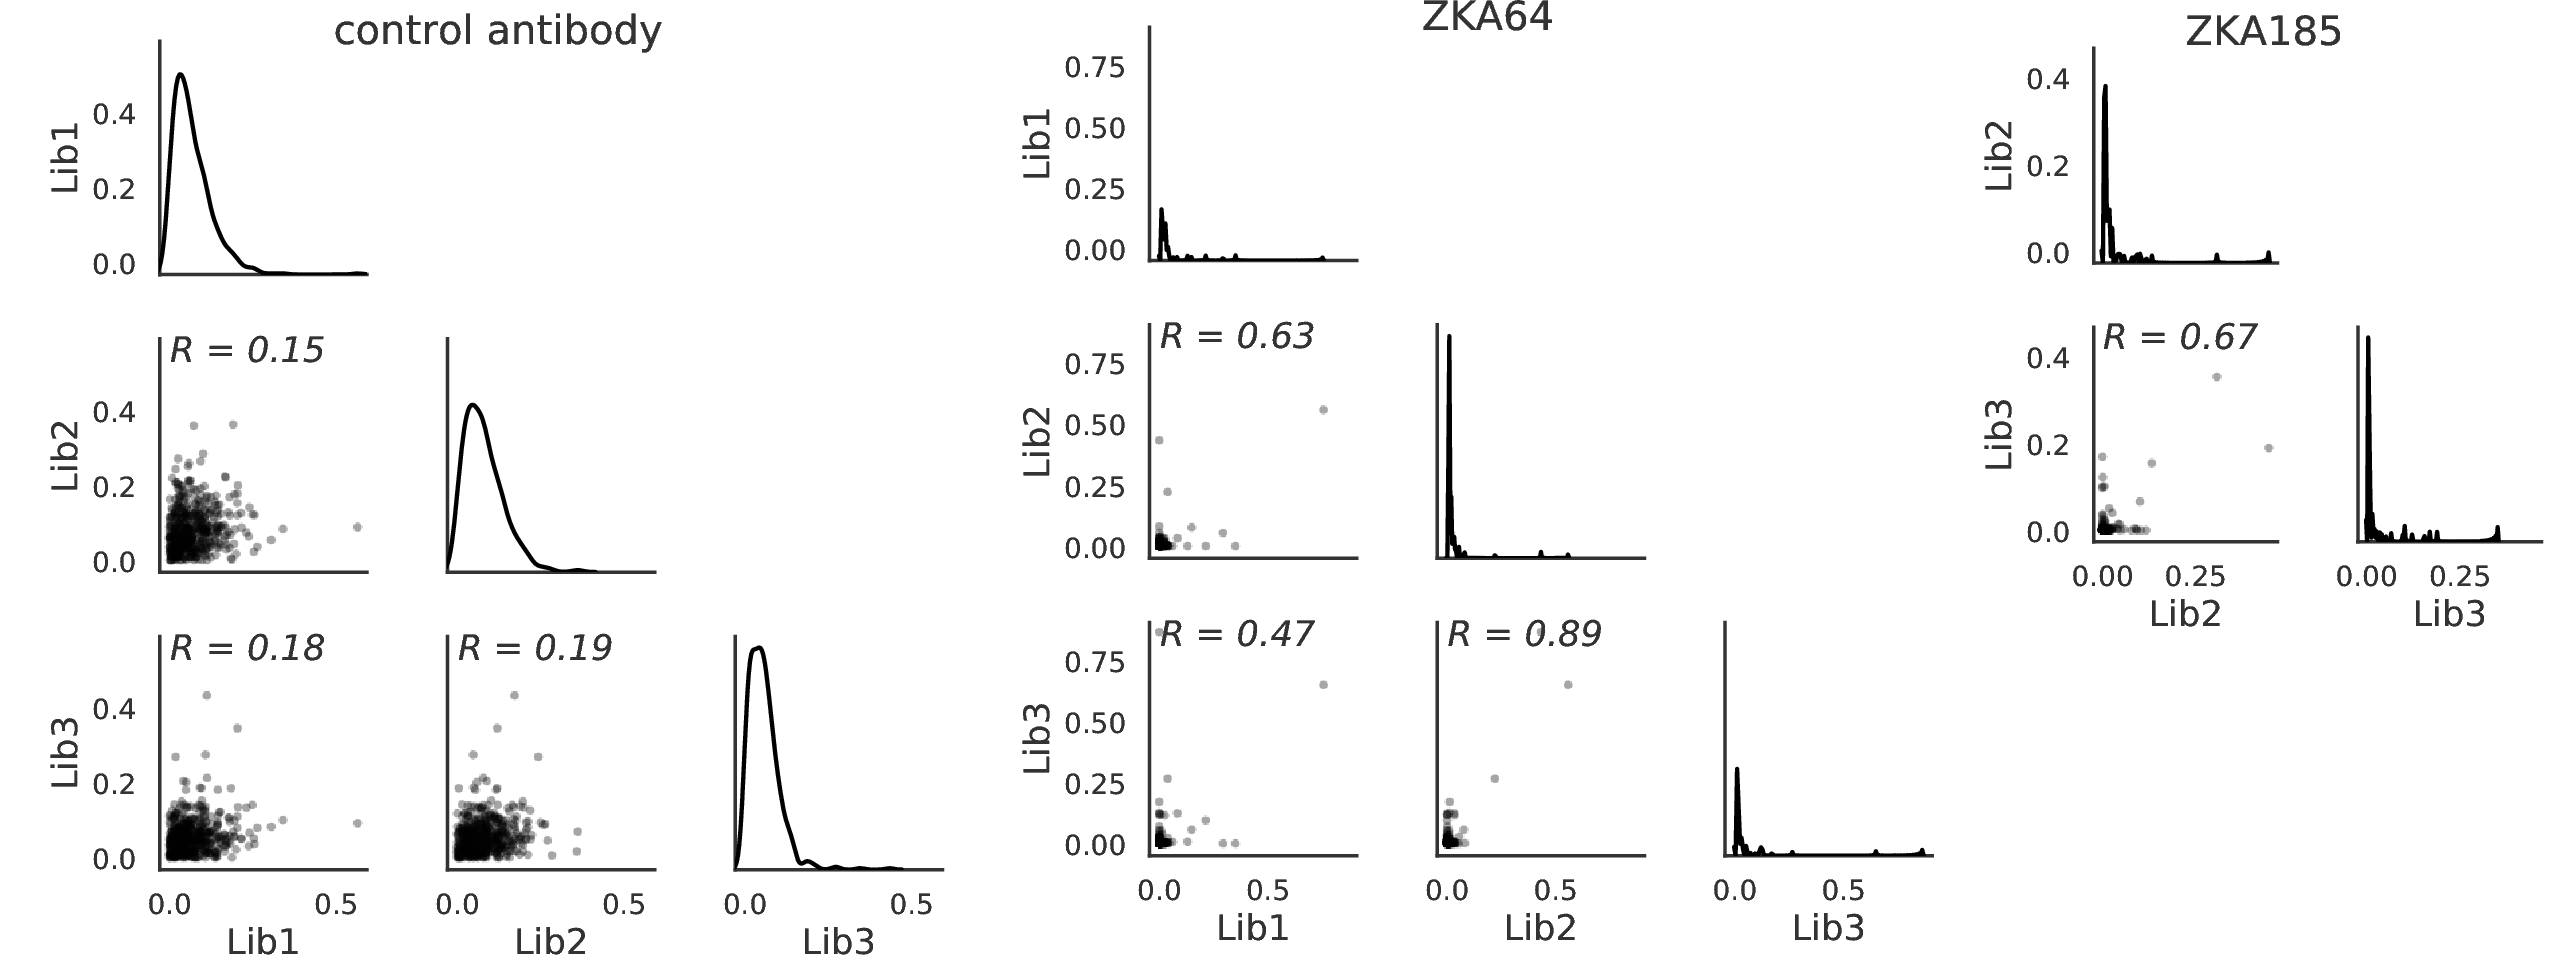

In [46]:
showPDF([os.path.join(fracsurvivedir, f'summary_{antibody}-avgfracsurvivecorr.pdf')
         for antibody in diffsel_batch['group'].unique()])

Here is the mean across replicates of each site's average fracsurvive:

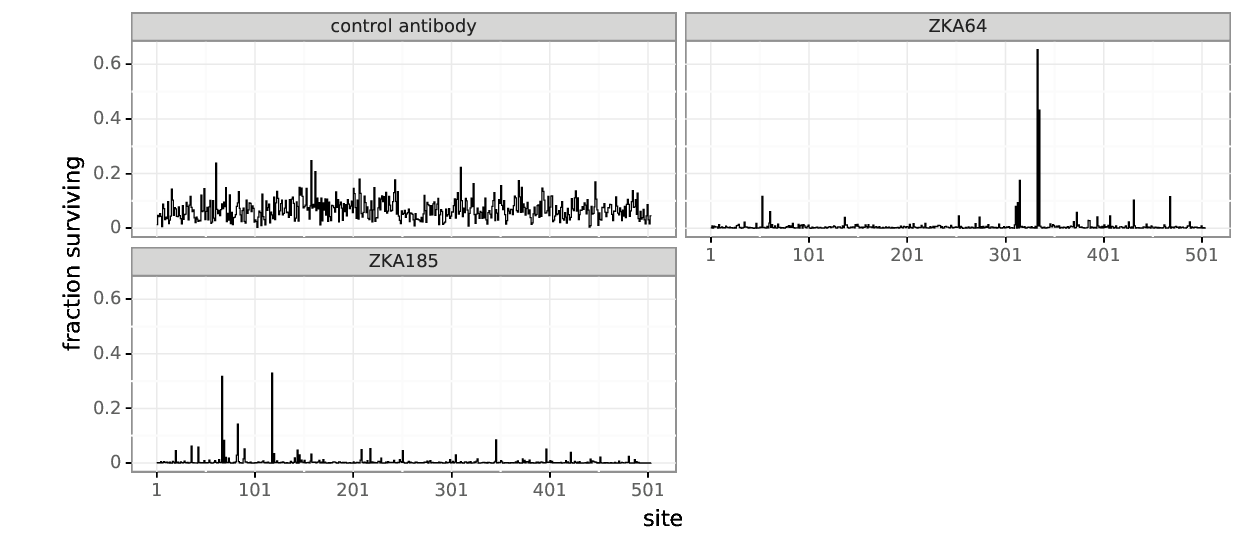

In [47]:
showPDF(os.path.join(fracsurvivedir, 'summary_meanavgfracsurvive.pdf'))

Finally, we use [dms2_logoplot](https://jbloomlab.github.io/dms_tools2/dms2_logoplot.html) to make a logo plot of the mean across-replicate fraction surviving for each non-control antibody:



Fracsurvive for ZKA64 (plot saved to ./results/logoplots/ZKA64_fracsurvive.pdf):


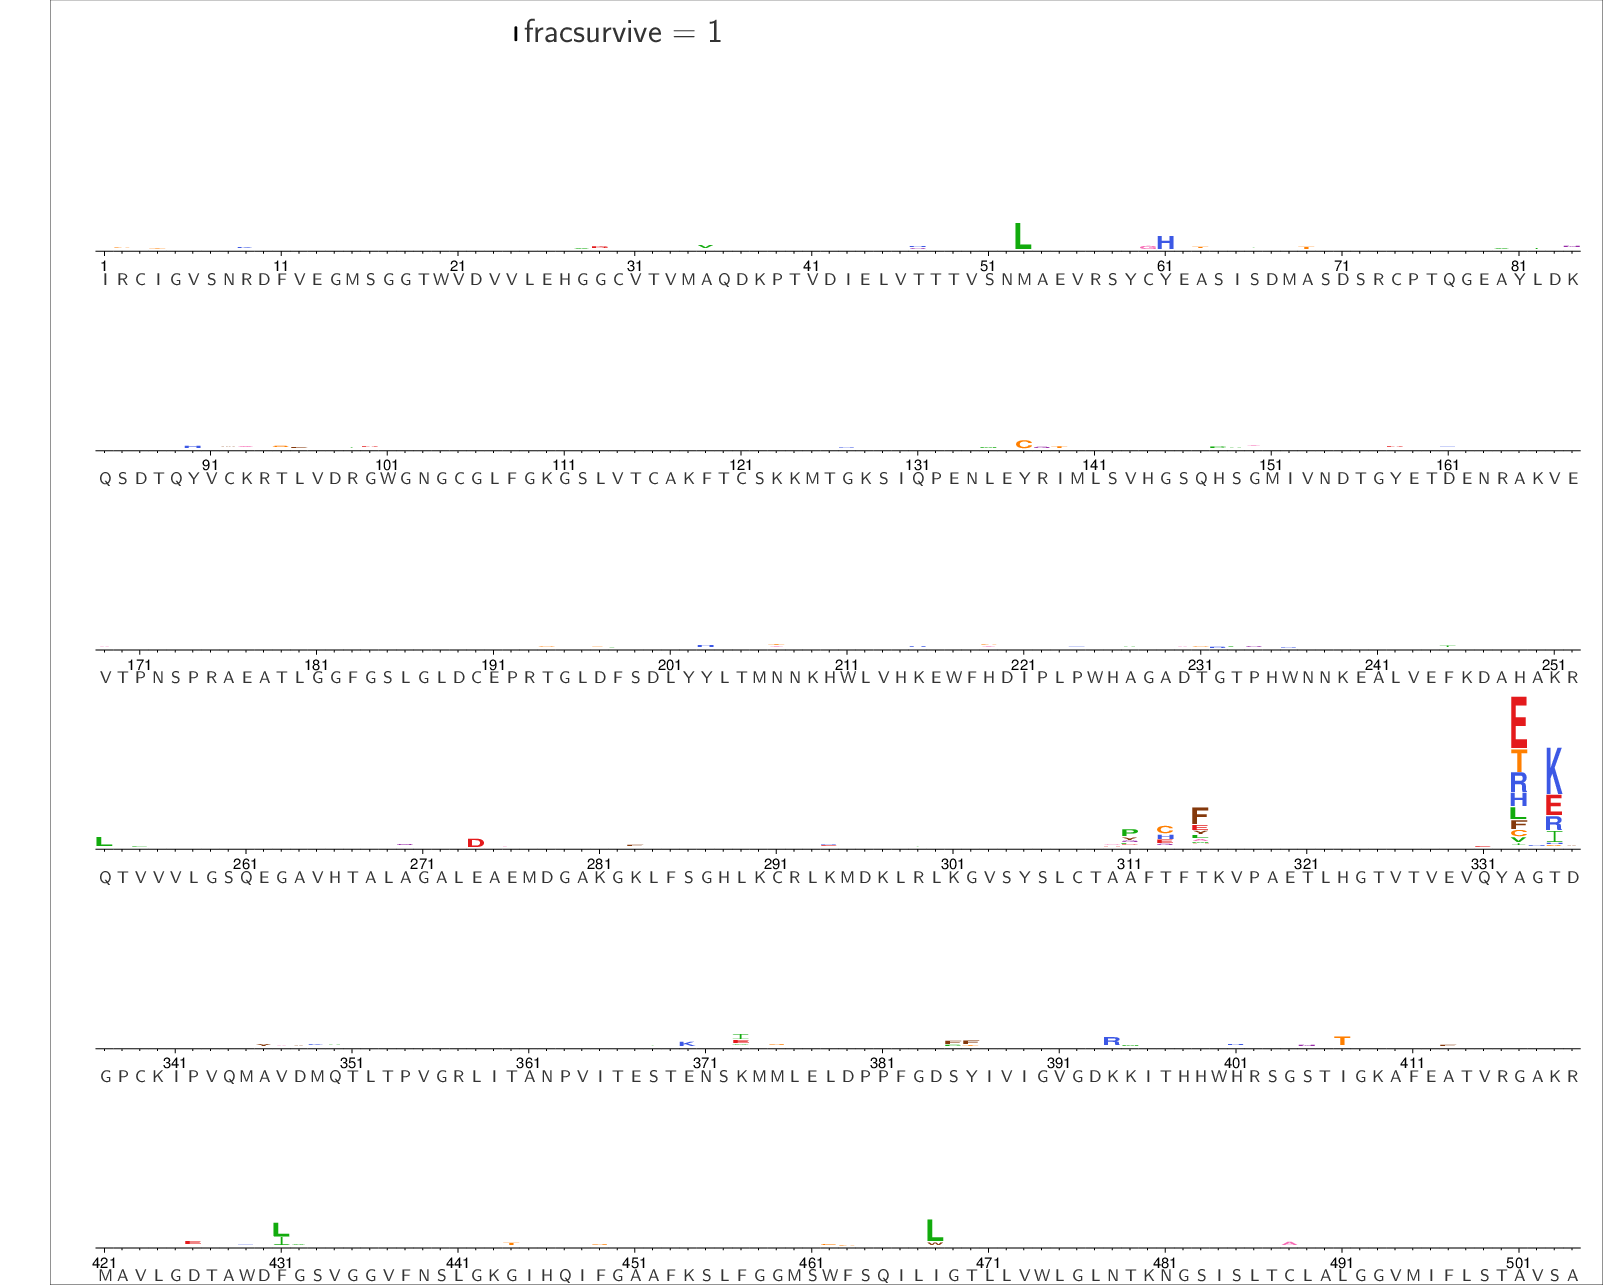



Fracsurvive for ZKA185 (plot saved to ./results/logoplots/ZKA185_fracsurvive.pdf):


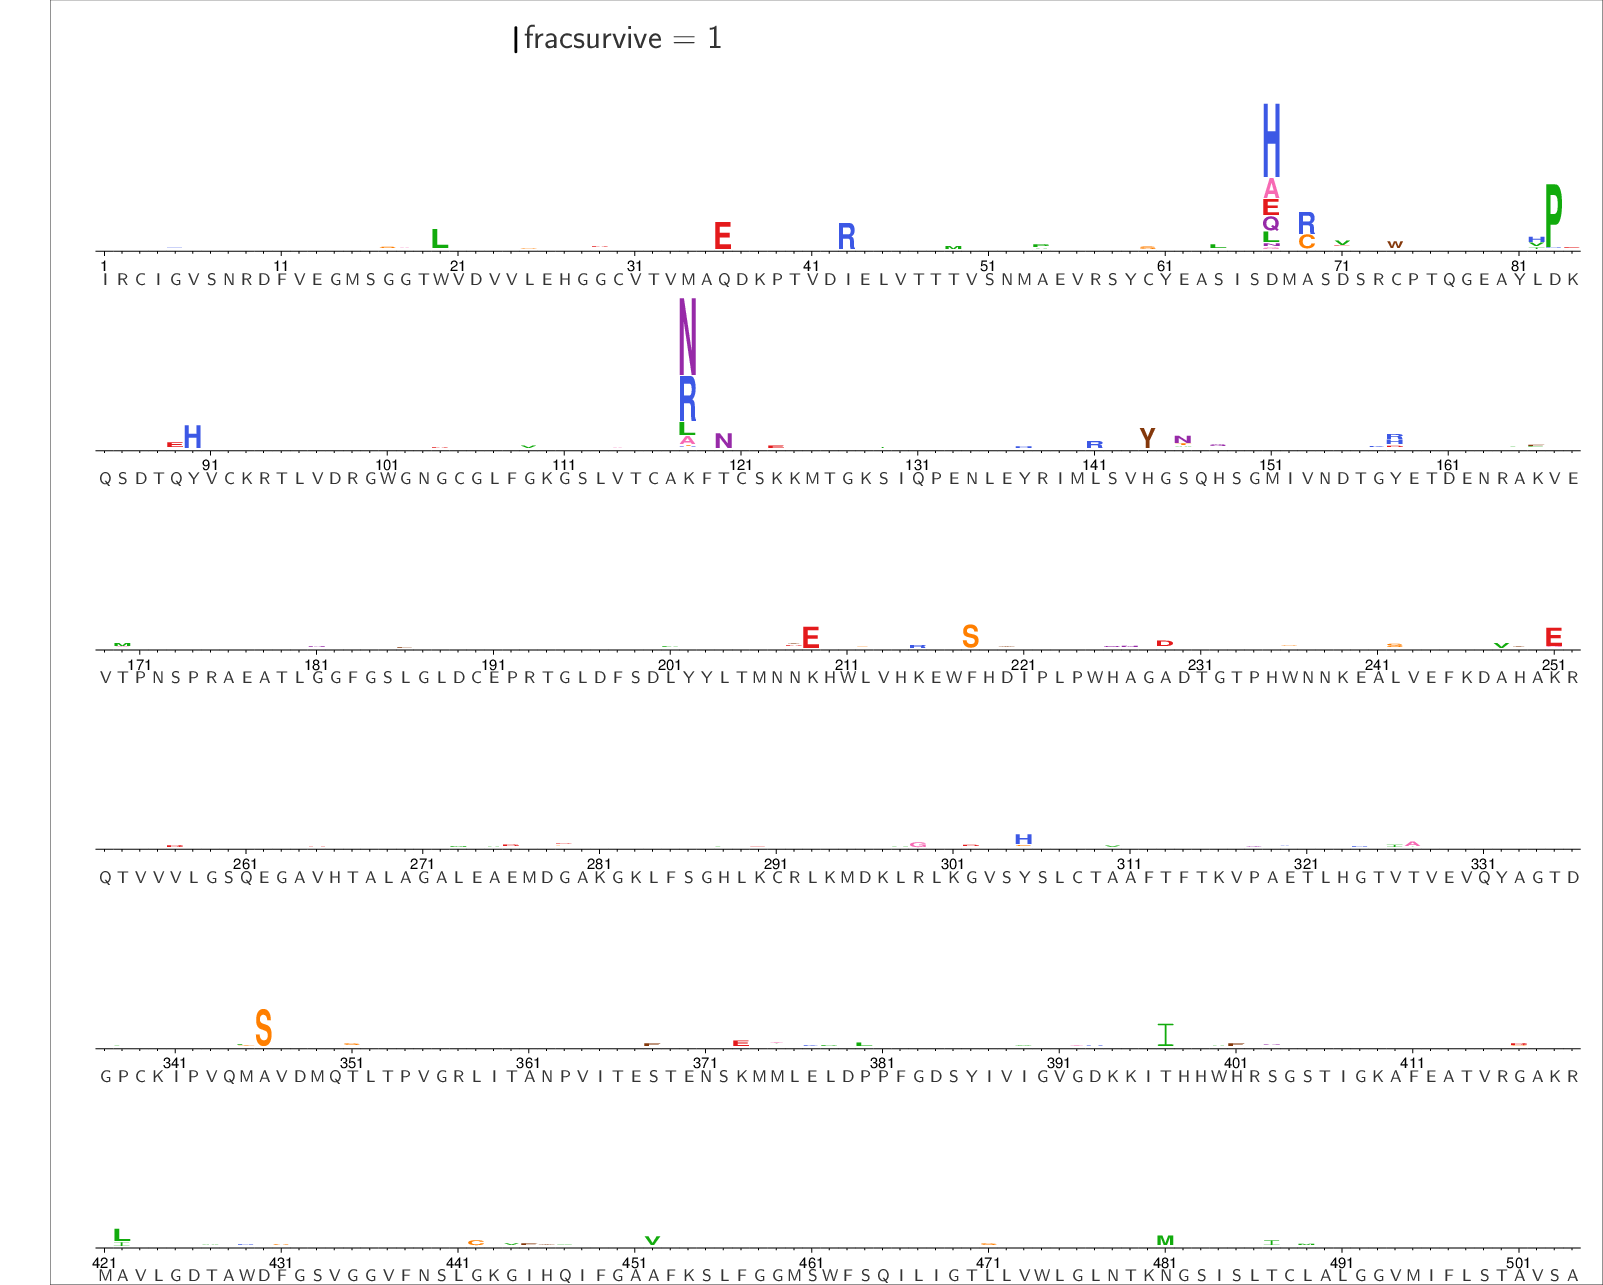

In [48]:
for antibody in diffsel_batch.query('group != "control-antibody"').group.unique():
    logoplot = os.path.join(logodir, f"{antibody}_fracsurvive.pdf")
    fracsurvivefile = os.path.join(fracsurvivedir,
                               f'summary_{antibody}-meanmutfracsurvive.csv')
    print(f"\n\nFracsurvive for {antibody} (plot saved to {logoplot}):")
    log = ! dms2_logoplot \
        --outdir {logodir} \
        --name {antibody} \
        --fracsurvive {fracsurvivefile} \
        --nperline 84 \
        --overlay1 {wtoverlayfile} wildtype wildtype \
        --scalebar 1 "fracsurvive = 1" \
        --underlay yes \
        --use_existing no
    showPDF(logoplot)

The results for fraction surviving look mostly similar to those for differential selection, but there are some differences, and it is probably worth considering which metric seems to better capture the real biology.

## Mutations tested by Evans lab
The Evans lab has tested some mutations in growth assays.
Here we look at how their measurements compare to the deep mutational scanning.

Create a directory for this analysis:

In [49]:
experimentsdir = os.path.join(resultsdir, 'experiments')
os.makedirs(experimentsdir, exist_ok=True)

Here we manually enter the mutations characterized by the Evans lab, visually inspecting their data to describe growth phenotypes:

In [50]:
# manually enter data from Evans lab
tested_mutations = (
    pandas.DataFrame.from_records([
        ('C190S', 'no growth'),
        ('P192I', 'no growth'),
        ('P354R', 'good growth'),
        ('G106A', 'good growth'),
        ('T194R', 'good growth'),
        ('G29L' , 'good growth'),
        ('S403I', 'good growth'),
        ('K443M', 'good growth'), # almost wildtype
        ('Q447C', 'good growth'),
        ('F285S', 'attenuated'),
        ('V437A', 'good growth'),
        ('T487M', 'good growth'),
        ('G29A' , 'good growth'),
        ('V169L', 'good growth')
        ], columns=['mutation', 'phenotype'])
    )

# extract wildtype amino acid, site, and mutant amino acid
tested_mutations = (
    tested_mutations
    .join(tested_mutations.mutation.str.extractall(
          '^(?P<wt_aa>[A-Z])(?P<site>\d+)(?P<mut_aa>[A-Z])$')
          .reset_index(drop=True))
    )

display(HTML(tested_mutations.to_html(index=False)))

mutation,phenotype,wt_aa,site,mut_aa
C190S,no growth,C,190,S
P192I,no growth,P,192,I
P354R,good growth,P,354,R
G106A,good growth,G,106,A
T194R,good growth,T,194,R
G29L,good growth,G,29,L
S403I,good growth,S,403,I
K443M,good growth,K,443,M
Q447C,good growth,Q,447,C
F285S,attenuated,F,285,S


Now we want to plot the amino-acid preferences at just these sites.
We plot both the re-scaled and un-scaled amino-acid preferences for the tested sites using [dms_tools2.replot.siteSubsetGGSeqLogo](https://jbloomlab.github.io/dms_tools2/dms_tools2.rplot.html#dms_tools2.rplot.siteSubsetGGSeqLogo):



rescaled preferences at tested sites:


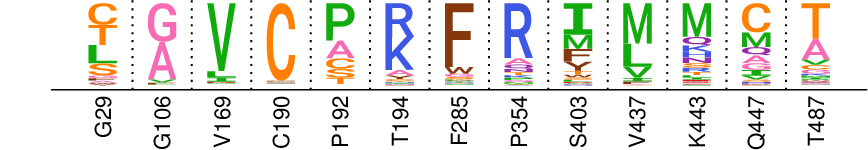



unscaled preferences at tested sites:


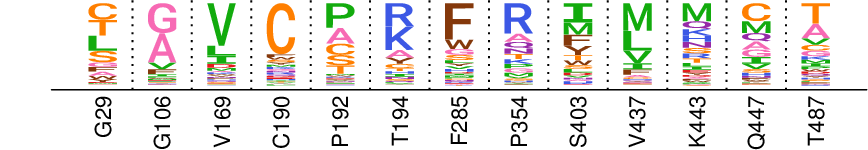

In [51]:
for scaling, df in [('rescaled', rescaledprefs), 
                    ('unscaled', unscaledprefs)]:

    tested_prefslogo = os.path.join(experimentsdir,
                                    f'tested_{scaling}_prefs.pdf')

    dms_tools2.rplot.siteSubsetGGSeqLogo(
        df.assign(show=lambda x: x['site'].isin(tested_mutations.site),
                  site=lambda x: x.labeledsite),
        AAS,
        tested_prefslogo,
        width=0.5 * len(tested_mutations.site.unique()),
        height=1.5)

    print(f"\n\n{scaling} preferences at tested sites:")
    showPDF(tested_prefslogo)

The logo plots above show the amino-acid preferences, although it is sometimes hard to see the relative effects of mutations with small preferences.

The expected effect of a mutation (i.e., the selection coefficient) is related to the ratio of the preferences for the wildtype and mutant amino acids.
Specifically, if the preference for the wildtype amino acid is $\pi_{\rm{wt}}$ and the preference for the mutant amino acid is $\pi_{\rm{mut}}$, then the effect of that mutation is the log of the ratio of preferences: 
$$s_{\rm{wt}\rightarrow\rm{mut}} = \log_2 \left(\frac{\pi_{\rm{mut}}}{\pi_{\rm{wt}}}\right).$$

In other words, the effect of the mutation is the log of the ratio of the letter heights.

Use [dms_tools2.prefs.prefsToMutEffects](https://jbloomlab.github.io/dms_tools2/dms_tools2.prefs.html#dms_tools2.prefs.prefsToMutEffects) function to convert preferences to estimated mutational effects.
Note that in the formula above the re-scaling is just a constant multiplicative factor and so does not affect these mutational effects beyond a change of units, so we just use the re-scaled preferences.

First, get a data frame of the effects for all nonsynonymous mutations away from the wildtype amino acid:

In [52]:
muteffects = (dms_tools2.prefs.prefsToMutEffects(rescaledprefs.drop(columns=['wildtype', 'labeledsite']), 
                                                 dms_tools2.AAS)
              # do not include synonymous mutations
              .rename(columns={'initial':'wt_aa', 'final':'mut_aa'})
              .query('wt_aa != mut_aa')
              # only include mutations from wildtype amino acid
              .merge(wt_aas, on='site', how='inner')
              .query('wildtype == wt_aa')
              .drop(['wildtype', 'effect'], axis='columns')
              .reset_index(drop=True)
              )

Plot the overall distribution of mutational effects.
As expected, most mutations are deleterious:

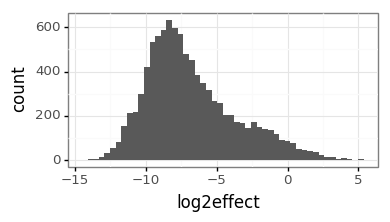

In [53]:
_ = (
    ggplot(muteffects, aes('log2effect')) +
    geom_histogram(bins=50) +
    theme(figure_size=(4, 2))
    ).draw()

Now we get the effects of the experimentall characterized mutations:

In [54]:
tested_mutations = (
    tested_mutations
    .drop('log2effect', axis='columns', errors='ignore')
    .merge(muteffects[['mutation', 'log2effect']])
    .sort_values('log2effect')
    .reset_index(drop=True)
    )

display(HTML(tested_mutations.to_html()))

,mutation,phenotype,wt_aa,site,mut_aa,log2effect
0,P192I,no growth,P,192,I,-8.381668
1,C190S,no growth,C,190,S,-7.062388
2,F285S,attenuated,F,285,S,-4.592261
3,T487M,good growth,T,487,M,-4.300170
4,V437A,good growth,V,437,A,-3.809977
5,V169L,good growth,V,169,L,-3.472037
6,G29A,good growth,G,29,A,-0.221108
7,G106A,good growth,G,106,A,-0.051554
8,Q447C,good growth,Q,447,C,1.813139
9,K443M,good growth,K,443,M,2.484824


Finally, we plot the distribution of the effects of all mutations with the measurements for the specific characterized mutations overlaid:

/fh/fast/bloom_j/software/conda/envs/BloomLab_v2/lib/python3.6/site-packages/plotnine/layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or


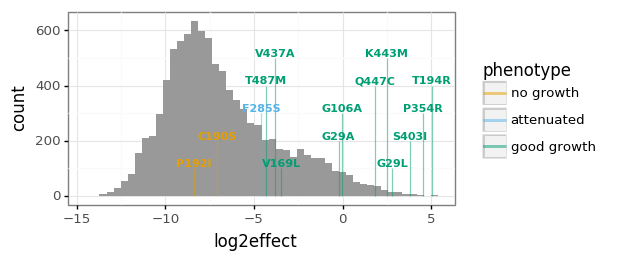

In [55]:
# labels with y values for plotting
label_data = (
    tested_mutations
    .assign(y=lambda x: 100 * (1 + x.index % 5),
            phenotype=lambda x: pandas.Categorical(x.phenotype,
                ['no growth', 'attenuated', 'good growth'], ordered=True))  
    )

_ = (
    ggplot(muteffects, aes('log2effect')) +
    geom_histogram(fill=PALETTE[0], bins=50) +
    geom_segment(aes(x='log2effect', xend='log2effect',
                     y=0, yend='y', color='phenotype'),
                 data=label_data, alpha=0.5) +
    geom_text(aes(label='mutation', x='log2effect', 
                  y='y', color='phenotype'),
              data=label_data, size=8, va='bottom',
              fontweight='semibold', show_legend=False) +
    scale_color_manual(PALETTE[1 : ]) +
    theme(figure_size=(5, 2.5))
    ).draw()

The histogram above suggests that the correlation between the experiments and deep mutational scanning is OK. 
There are a few mutations that the deep mutational scanning suggests should be moderately deleterious that are in fact tolerated fine, but overall most of the tested mutations are not predicted to be highly deleterious.

## Choose "significant" antibody-escape mutations for validation
We will now choose some antibody-escape mutations and good controls for validation experiments.
We will do this using the excess fraction surviving (*fracsurvive*) values that we computed above.

Make a directory for these results:

In [56]:
antibodyescapedir = os.path.join(resultsdir, 'antibody_escape')
os.makedirs(antibodyescapedir, exist_ok=True)

Read the data for *fracsurvive* from the CSV files into pandas Data Frames with the site-level and mutation-level information:

In [57]:
# list of 2-tuples for all antibodies / library replicates
antibodies_libs = list(diffsel_batch
                       .rename(columns={'group':'antibody', 'name':'lib'})
                       [['antibody', 'lib']]
                       .itertuples(index=False)
                       )

# list of unique antibodies
antibodies = diffsel_batch.group.unique().tolist()
libraries = diffsel_batch.name.unique().tolist()

# Get mutation and site values for each replicate, and the replicate means
antibody_mutvals = []
antibody_sitevals = []

# values for each replicate
for antibody, lib in antibodies_libs:
    for valtype, vallist in [('mut', antibody_mutvals),
                             ('site', antibody_sitevals)]:
        csvfile = f'{fracsurvivedir}/{antibody}-{lib}_{valtype}fracsurvive.csv'
        vallist.append(
                pandas.read_csv(csvfile)
                .assign(antibody=antibody, library=lib))

# values for average across replicates
for antibody in antibodies:
    for valtype, vallist in [('mut', antibody_mutvals),
                             ('site', antibody_sitevals)]:
        csvfile = f'{fracsurvivedir}/summary_{antibody}-mean{valtype}fracsurvive.csv'
        vallist.append(
                pandas.read_csv(csvfile)
                .assign(antibody=antibody, library='average'))
        
antibody_mutvals = pandas.concat(antibody_mutvals)
antibody_sitevals = pandas.concat(antibody_sitevals)

Now we use [dms_tools2.plot.findSigSel](https://jbloomlab.github.io/dms_tools2/dms_tools2.plot.html#dms_tools2.plot.findSigSel) to compute the "significance" of each site of escape, reported as a Q-value that the the average excess fraction surviving for this site exceeds that fit by a gamma distribution to all sites.
We compute this for each replicate separately:

In [58]:
sigsel = []
for antibody in antibodies:
    for lib in antibody_sitevals.query('antibody == @antibody').library.unique():
        plotfile = os.path.join(antibodyescapedir, f'sigsites_{antibody}_{lib}.pdf')
        isigsel, cutoff, fit = dms_tools2.plot.findSigSel(
                                antibody_sitevals
                                    .query('antibody == @antibody')
                                    .query('library == @lib'), 
                                'avgfracsurvive',
                                 plotfile,
                                title=f'{antibody} {lib}')
        sigsel.append(isigsel)

sigsel = pandas.concat(sigsel)

For each site, get the number of replicates that call that site as "significant":

In [59]:
sigsel = (sigsel
          .query('library != "average"')
          .query('Q < 1e-4')
          .groupby(['site', 'antibody'])
          .size()
          .rename('nsignificant')
          .reset_index()
          .merge(sigsel)
          )

Now tabulate as "most significant" sites the ones were at least two replicates called that site as "significant" using the cutoff in the cell above:

In [60]:
sigsites = (
          sigsel
          .query('nsignificant >= 2')
          .pivot_table(index=['antibody', 'site'],
                       columns='library',
                       values='Q')
          .reset_index()
          .sort_values('average')
          )

display(HTML(sigsites
             .sort_values(['antibody', 'average'])
             .to_html(index=False)
             ))

library,antibody,site,Lib1,Lib2,Lib3,average
,ZKA185,118,NaN,1.653277e-23,2.096795e-34,1.426303e-74
,ZKA185,67,NaN,4.175244e-34,1.837303e-18,3.510260e-72
,ZKA185,83,NaN,5.304265e-10,3.036935e-15,7.189542e-32
,ZKA185,69,NaN,8.571074e-08,9.888048e-07,2.890496e-18
,ZKA64,333,1.391771e-26,3.171858e-13,3.105912e-27,3.492285e-83
,ZKA64,335,1.000000e+00,1.993384e-10,3.602459e-36,1.268177e-54
,ZKA64,315,1.220183e-01,2.671686e-05,6.336930e-11,3.153809e-21


Now use [dms_tools2.rplot.siteSubsetGGSeqLogo](https://jbloomlab.github.io/dms_tools2/dms_tools2.rplot.html#dms_tools2.rplot.siteSubsetGGSeqLogo) to plot the fraction surviving at each of these "most significant" sites for each antibody, using the across-replicate average values.
Since we might want to use the escape mutations from one antibody as controls for another, we plot the escape sites for both antibodies combined for each antibody.
Even though we are classifying escape based on *fracsurvive*, we also plot **positive** *diffsel*.
In addition, we plot the amino-acid preferences (mutational tolerance) to see if there are tolerated mutations at a site that simply don't mediate escape:




Examining most significant sites of escape for ZKA64:



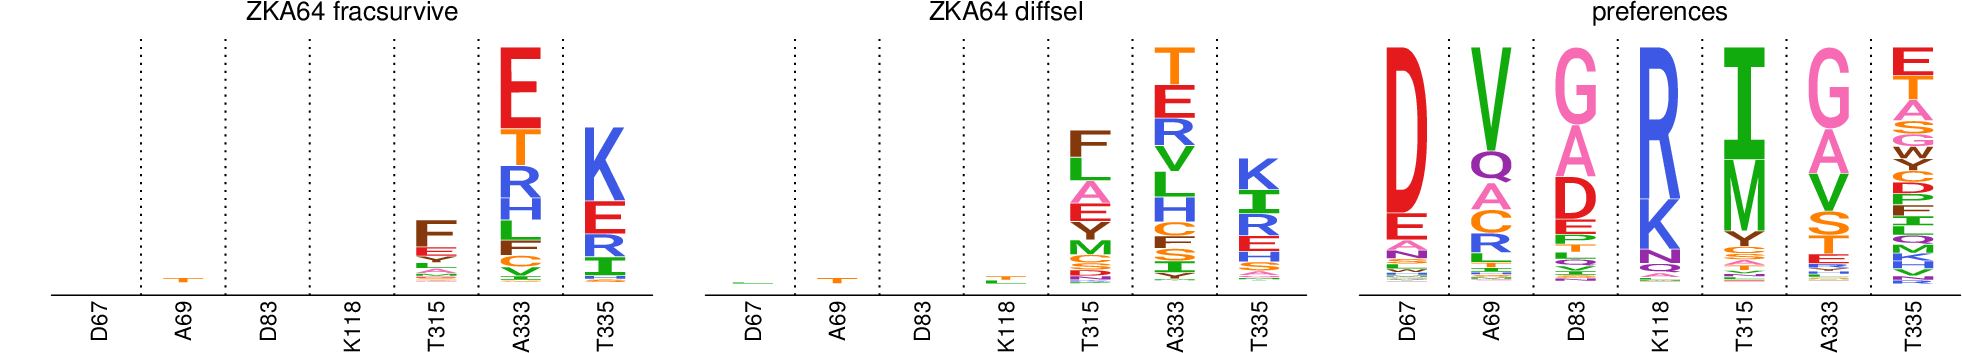




Examining most significant sites of escape for ZKA185:



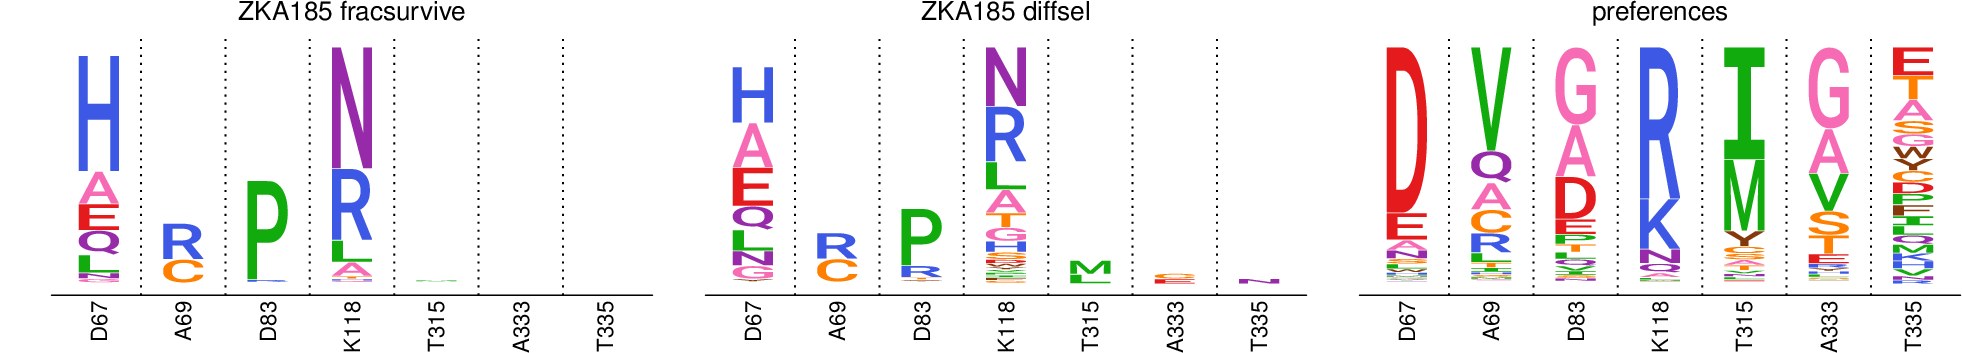

In [61]:
# plot all significant sites for both antibodies
antibody_sites = set(sigsites.site)

for antibody in antibodies:
    if antibody == 'control-antibody':
        continue
        
    print(f'\n\n\nExamining most significant sites of escape for {antibody}:\n')
        
    

    # data on escape for logo plot
    logodata = (
        antibody_mutvals
        .query('antibody == @antibody')
        .query('library == "average"')
        .assign(show=lambda x: x.site.isin(antibody_sites),
                site_num=lambda x: x.site,
                site=lambda x: x.wildtype + x.site.astype('str'))
        .pivot_table(index=['site_num', 'site', 'show', 'antibody'],
                     columns='mutation',
                     values='mutfracsurvive')
        .reset_index()
        .sort_values('site_num')
        )

    # plot fraction sruvive data 
    fracsurviveplotfile = os.path.join(antibodyescapedir, f'{antibody}_fracsurvive_zoom_logo.pdf')
    dms_tools2.rplot.siteSubsetGGSeqLogo(logodata,
                                         AAS,
                                         fracsurviveplotfile,
                                         width=0.7 * len(antibody_sites),
                                         height=3,
                                         title=f'{antibody} fracsurvive'
                                         )
    
    # plot differential selection
    diffseldata = (pandas.read_csv(
                        os.path.join(diffseldir,
                                    f'summary_{antibody}-meanmutdiffsel.csv'))
                   .assign(site_num=lambda x: x.site,
                           site=lambda x: x.wildtype + x.site.astype('str'),
                           show=lambda x: x.site_num.isin(antibody_sites),
                           mutdiffsel=lambda x: numpy.clip(x.mutdiffsel, 0, None))
                   .pivot_table(index=['site_num', 'site', 'show'],
                                columns='mutation',
                                values='mutdiffsel')
                   .reset_index()
                   .sort_values('site_num')
                   )
    diffselplotfile = os.path.join(antibodyescapedir, f'{antibody}_diffsel_zoom_logo.pdf')
    dms_tools2.rplot.siteSubsetGGSeqLogo(diffseldata,
                                         AAS,
                                         diffselplotfile,
                                         width=0.7 * len(antibody_sites),
                                         height=3,
                                         title=f'{antibody} diffsel'
                                         )
    
    # plot preferences (mutational tolerance)
    prefsplotfile = os.path.join(antibodyescapedir, f'{antibody}_prefs_zoom_logo.pdf')
    dms_tools2.rplot.siteSubsetGGSeqLogo(rescaledprefs
                                             .assign(
                                                show=lambda x: x.site.isin(antibody_sites),
                                                site=lambda x: x.labeledsite
                                              ),
                                         AAS,
                                         prefsplotfile,
                                         width=0.7 * len(antibody_sites),
                                         height=3,
                                         title='preferences'
                                         )
    
    showPDF([fracsurviveplotfile, diffselplotfile, prefsplotfile])

Based on the above, I would suggest the following mutations to test:

 - ZKA64 expected escape mutations:
   - T315F
   - A333E
   - T335K
   - T335E (in case T335K doesn't grow very well)
   
 - ZKA185 expected escape mutations:
   - D67H
   - D67E (in case D67H doesn't grow very well)
   - A69R
   - D83P
   - K118N
   
 - ZKA64 mutations expected **not** to escape:
   - any of ZKA185 escape mutations except perhaps those at site 69 and 118 (where there is very weak evidence for escape)
   - A333G: should be well tolerated for viral growth, but it doesn't appear to mediate escape. This shows only some mutations at site 333 mediate escape.
  
 - ZKA185 mutations expected **not** to escape:
   - most of the escape mutations for ZKA64, except perhaps at site 315 (where there is very weak evidence of escape)
   - D83A: should be well tolerated for viral growth, but it doesn't appear to mediate escape. This shows only some mutations at site 83 mediate escape.
   - A69V: should be well tolerated for viral growth, but it doesn't appear to mediate escape. This shows only mutations at site 69 escape.
   
If you only pick a subset so as not to have to test so many, I would suggest being sure to include the ones where we think only certain amino acids at a site will mediate escape. This would be:
 - A333E (should escape ZKA64) and A333G (should not escape ZKA64)
 - D83P (should escape ZKA185) and D83A (should not escape ZKA185)
 - A69R (should escape ZKA185) and A69V (should not escape ZKA185)


## Figures for paper
Here we generate plots for paper figures.

In [62]:
figsdir = os.path.join(resultsdir, 'figures')
os.makedirs(figsdir, exist_ok=True)

### Figures about library and selection
First, we want a plot that shows the sampling of mutations in the plasmid and virus libraries.
We've already made a similar plot above but it also shows antibody selections; here make one that just shows plasmid and virus.
First, get these samples and their codon counts files:

In [63]:
plasmid_and_virus_samples = (
    samples
    .query('selection in ["plasmid", "virus"]')
    [['name', 'library', 'selection']]
    .assign(countsfile=lambda x: countsdir + '/' + x.name + '_codoncounts.csv',
            name=lambda x: x['selection'] + ' ' + x['library'])
    )

display(HTML(plasmid_and_virus_samples.to_html(index=False)))

name,library,selection,countsfile
plasmid Lib1,Lib1,plasmid,./results/codoncounts/Lib1-plasmid_codoncounts...
plasmid Lib2,Lib2,plasmid,./results/codoncounts/Lib2-plasmid_codoncounts...
plasmid Lib3,Lib3,plasmid,./results/codoncounts/Lib3-plasmid_codoncounts...
plasmid wildtype,wildtype,plasmid,./results/codoncounts/wildtype-plasmid_codonco...
virus Lib1,Lib1,virus,./results/codoncounts/Lib1-virus_codoncounts.csv
virus Lib2,Lib2,virus,./results/codoncounts/Lib2-virus_codoncounts.csv
virus Lib3,Lib3,virus,./results/codoncounts/Lib3-virus_codoncounts.csv
virus wildtype,wildtype,virus,./results/codoncounts/wildtype-virus_codoncoun...


Now make plot of mutation sampling, just for mutant (non-wildtype) samples:

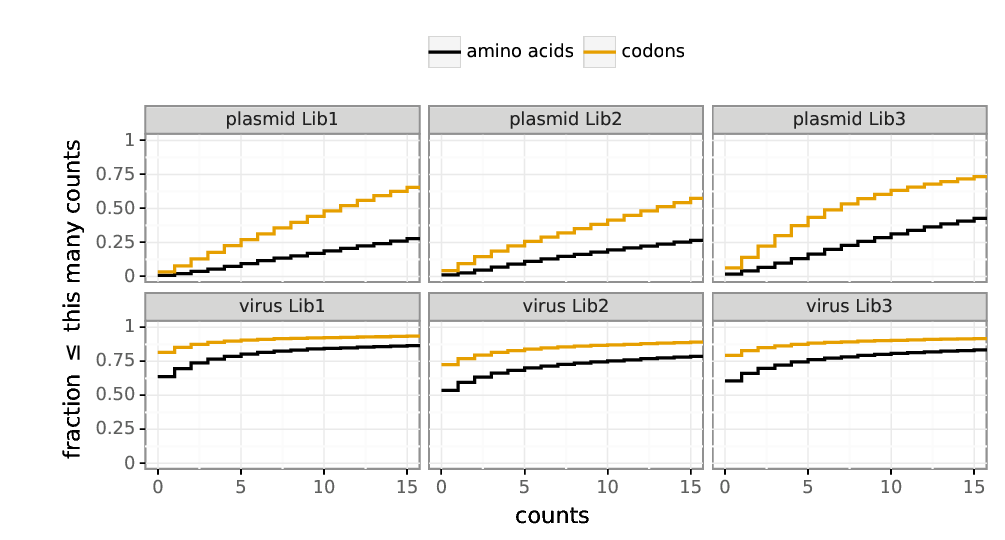

In [64]:
mutation_sampling = os.path.join(figsdir, 'mutation_sampling.pdf')

dms_tools2.plot.plotCumulMutCounts(
        names=plasmid_and_virus_samples.query('library != "wildtype"').name,
        countsfiles=plasmid_and_virus_samples.query('library != "wildtype"').countsfile,
        plotfile=mutation_sampling,
        chartype='codon',
        maxcol=3,
        )

showPDF(mutation_sampling)

And a plot of selection on different types of mutations:

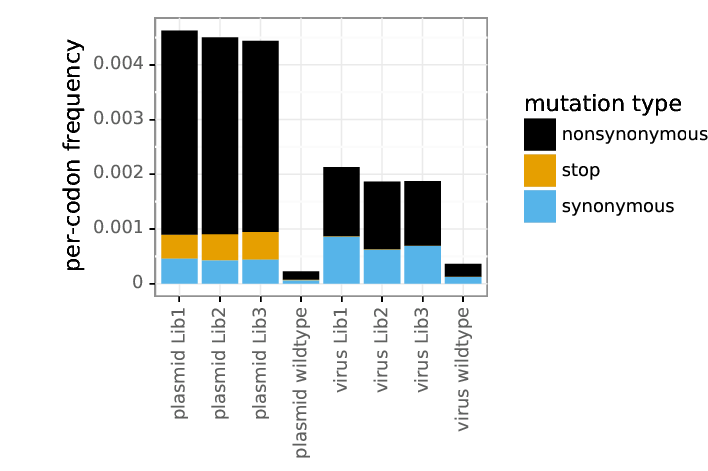

In [65]:
codon_mut_types = os.path.join(figsdir, 'codon_mut_types.pdf')

dms_tools2.plot.plotCodonMutTypes(
        names=plasmid_and_virus_samples.name,
        countsfiles=plasmid_and_virus_samples.countsfile,
        plotfile=codon_mut_types,
        )

showPDF(codon_mut_types)

We've already made a plot of replicate-replicate correlations in the measured mutational effects (amino-acid preferences), copy it here and show it:

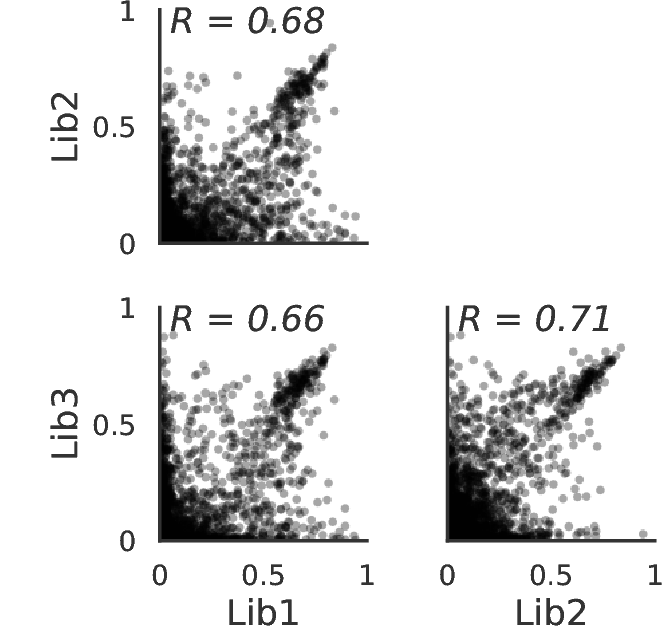

In [66]:
prefs_replicate_corr = os.path.join(figsdir, 'prefs_replicate_corr.pdf')
shutil.copy(os.path.join(prefsdir, 'summary_prefscorr.pdf'), prefs_replicate_corr)
showPDF(prefs_replicate_corr, width=300)

### Logo plots of mutational effects on viral growth
We use the logo plot of the unscaled preferences:

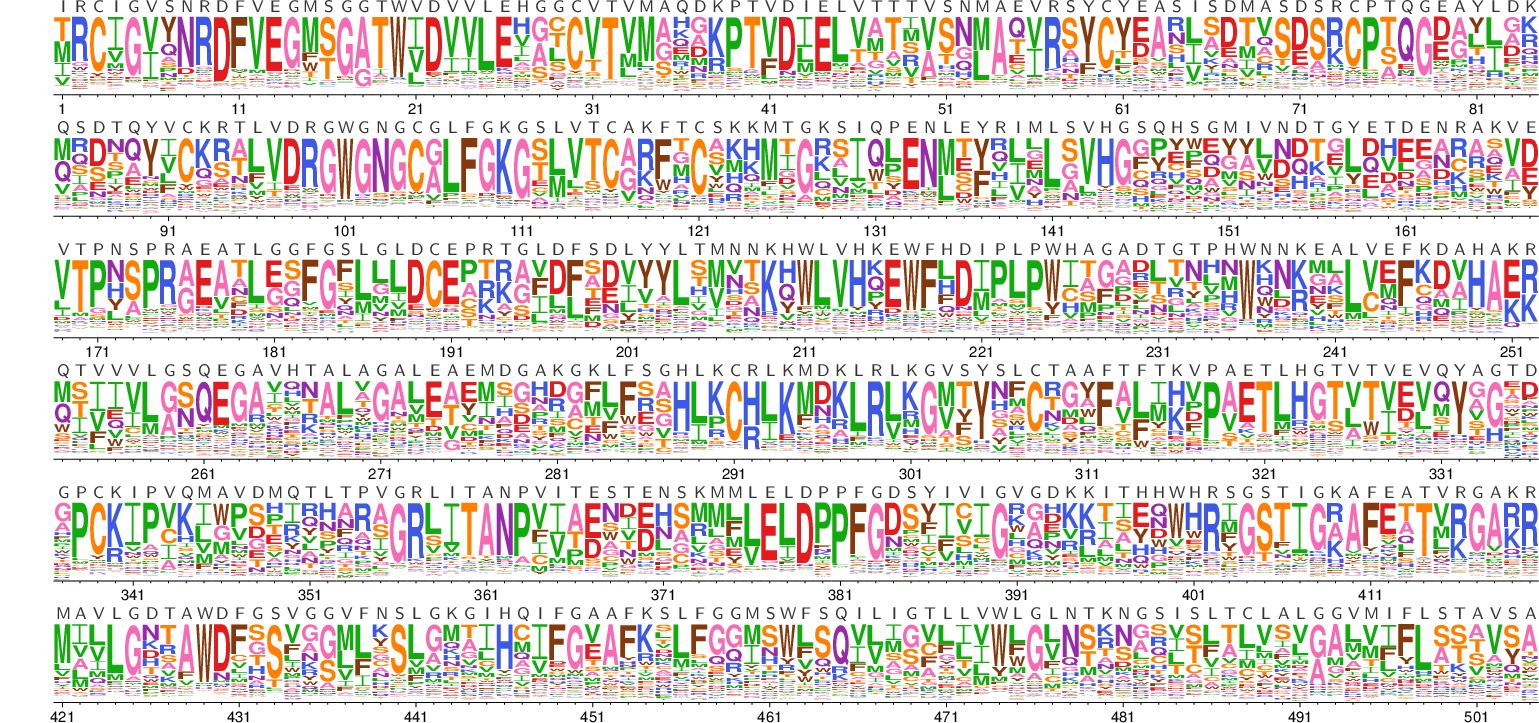

In [67]:
unscaled_prefs = os.path.join(figsdir, 'unscaled_prefs.pdf')
shutil.copy(os.path.join(logodir, 'unscaled_prefs.pdf'), unscaled_prefs)
showPDF(unscaled_prefs)

And the mutational effects on viral growth:

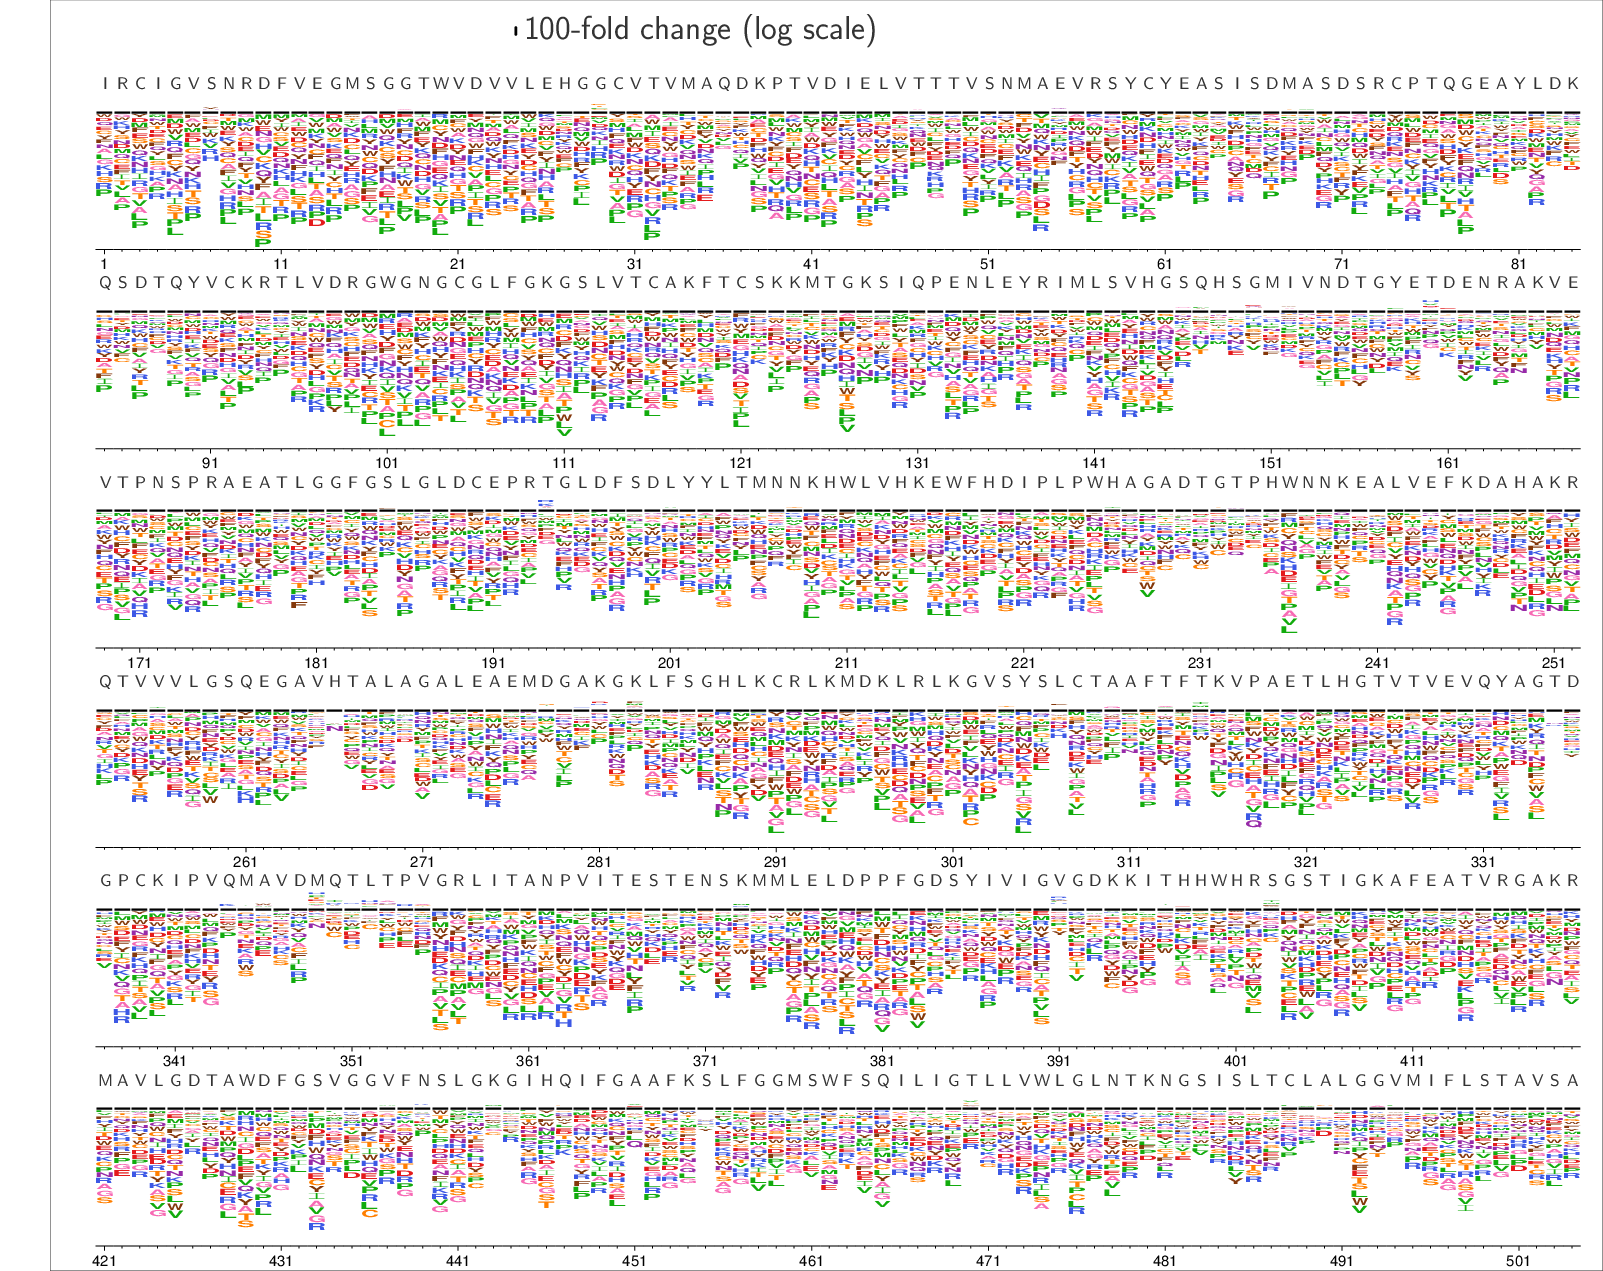

In [68]:
unscaled_muteffects = os.path.join(figsdir, 'unscaled_muteffects.pdf')
shutil.copy(os.path.join(logodir, 'unscaled_muteffects.pdf'), unscaled_muteffects)
showPDF(unscaled_muteffects)

### Comparison to natural evolution

Here is the tree:

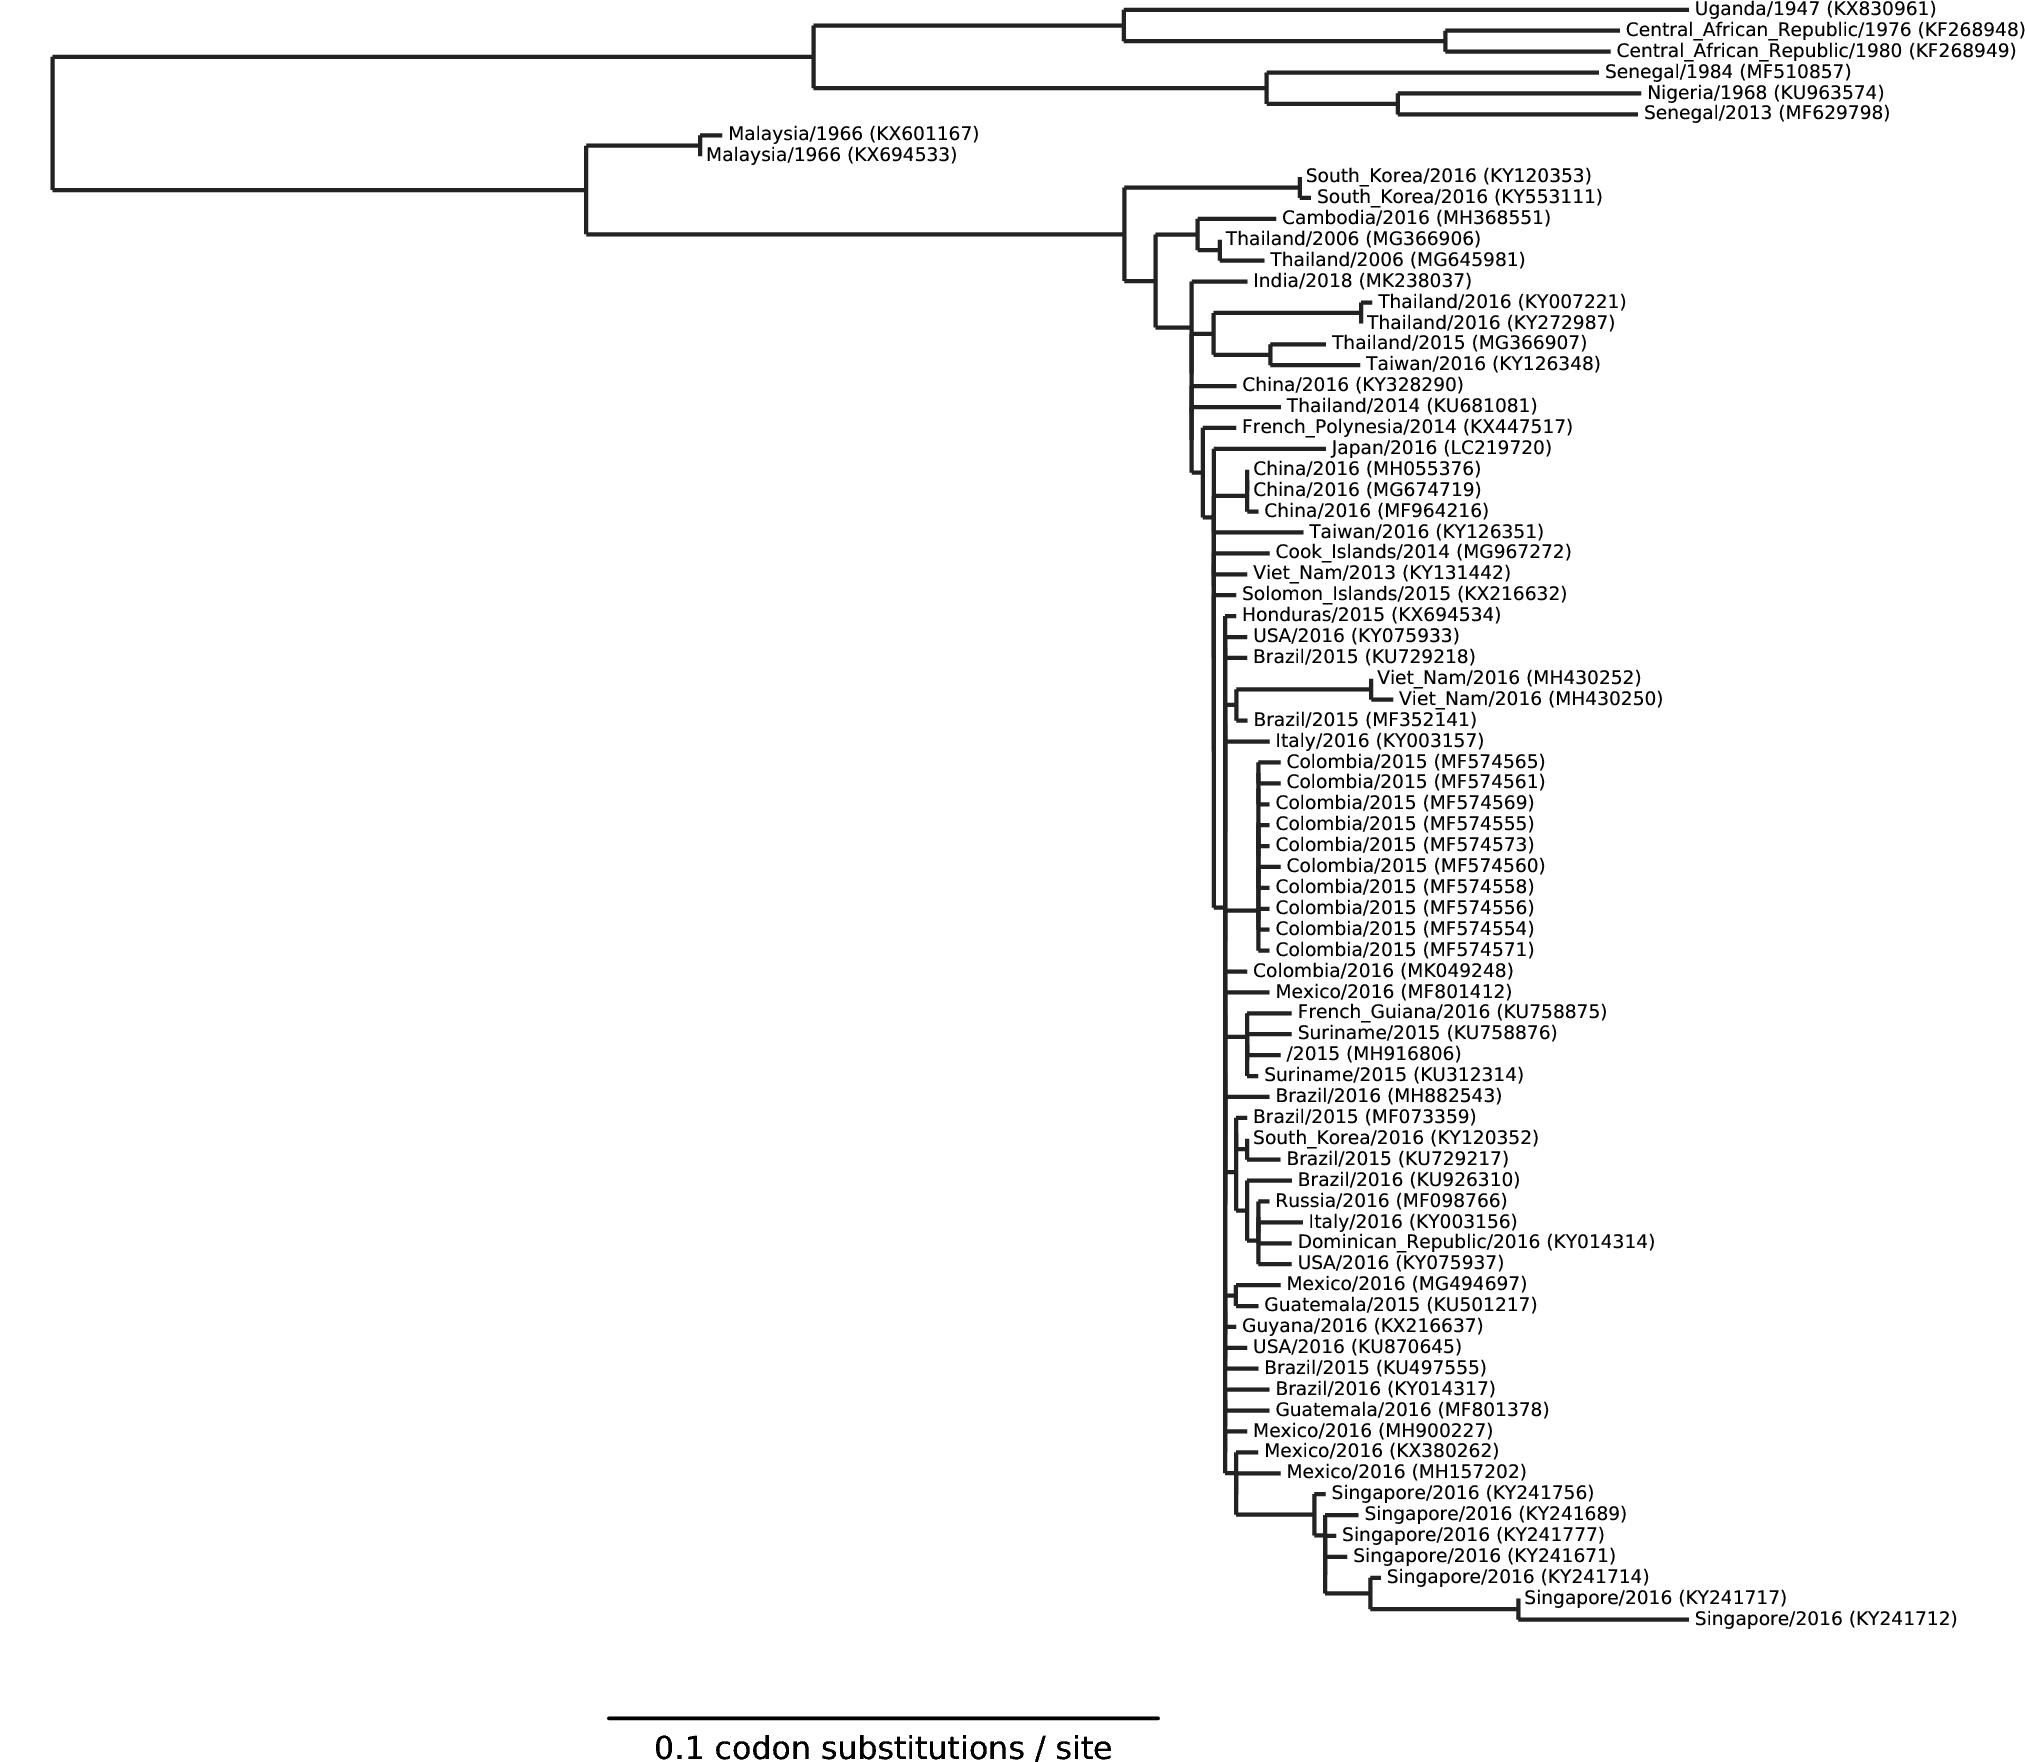

In [69]:
tree = os.path.join(figsdir, 'tree.pdf')
shutil.copy(treefigfile, tree)
showPDF(tree)

Show natural amino acid frequencies in this alignment:

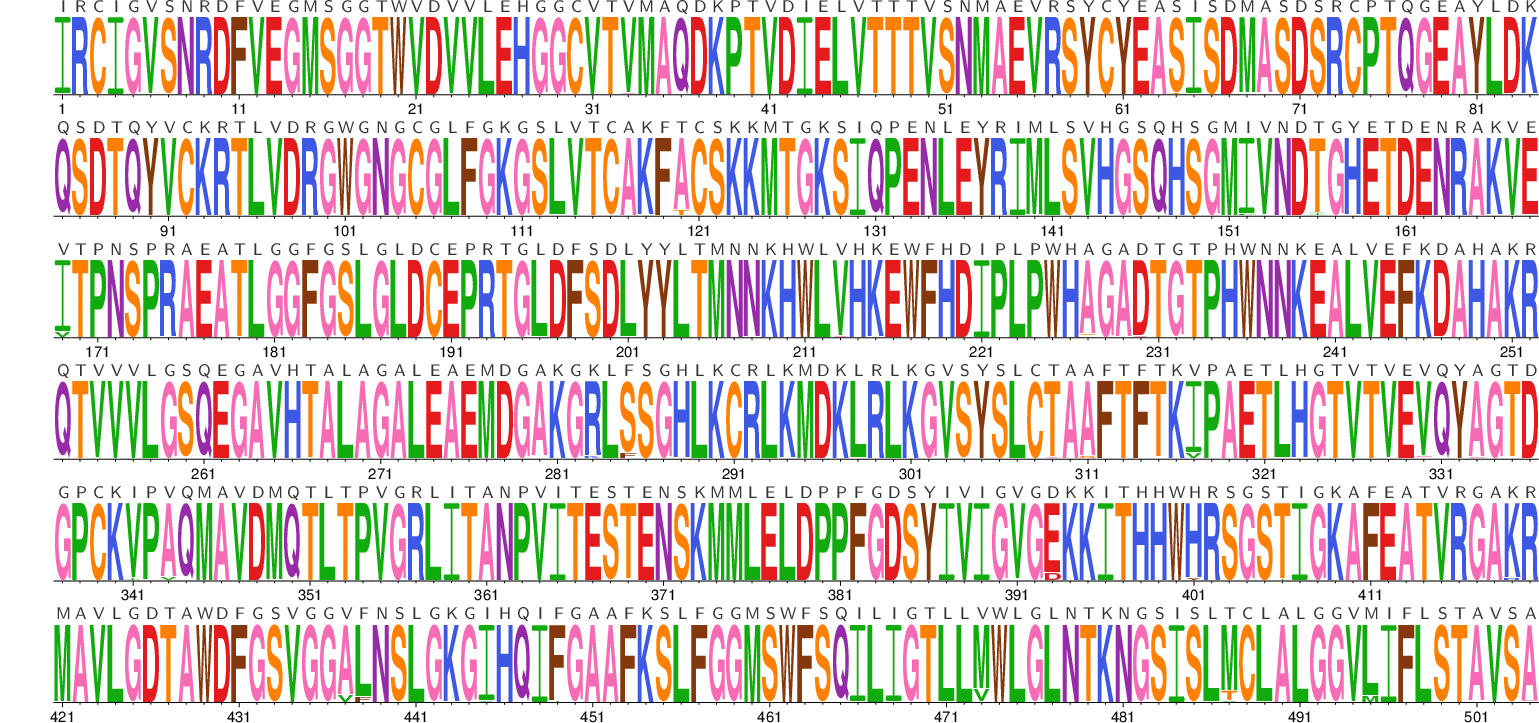

In [70]:
aafreqs = dms_tools2.prefs.aafreqsFromAlignment(alignment_file, True)
aafreqsfile = os.path.join(figsdir, 'natural_aafreqs.csv')
aafreqs.to_csv(aafreqsfile, index=False)

log = ! dms2_logoplot \
        --prefs {aafreqsfile} \
        --name aafreqs \
        --outdir {figsdir} \
        --nperline 84 \
        --overlay1 {wtoverlayfile} wildtype wildtype 

showPDF(os.path.join(figsdir, 'aafreqs_prefs.pdf'))

### Antibody escape
Make zoomed figures:

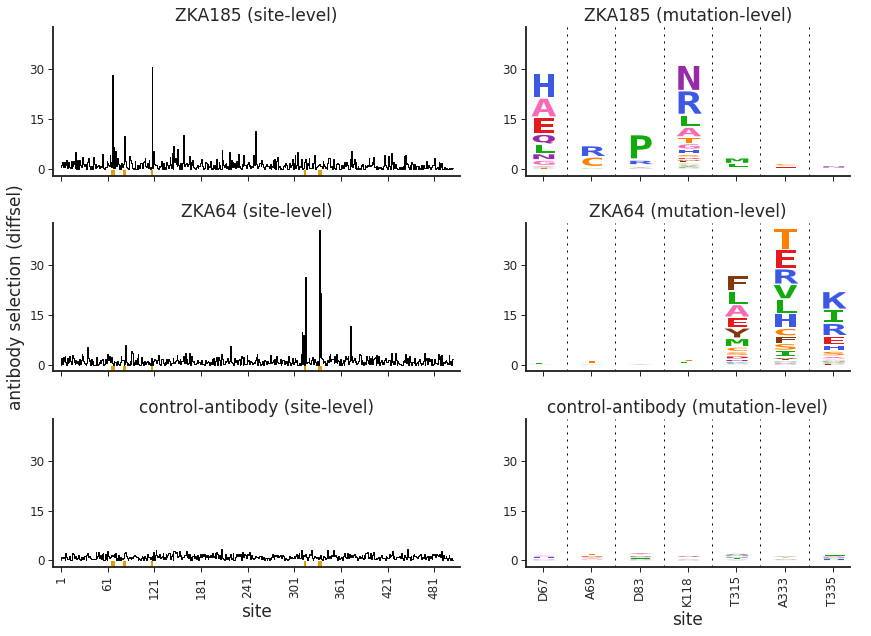

In [71]:
zoomsites = [315, 333, 335, 67, 118, 69, 83]

antibody_info = pandas.DataFrame(
                 {'antibody': antibodies,
                  'sitediffsel_file': [os.path.join(diffseldir,
                                       f"summary_{a}-meansitediffsel.csv") for
                                       a in antibodies],
                  'mutdiffsel_file': [os.path.join(diffseldir,
                                      f"summary_{a}-meanmutdiffsel.csv") for
                                      a in antibodies]
                  })

antibodydata = (dms_tools2.diffsel.df_read_filecols(antibody_info,
                                                    filecols=['sitediffsel_file',
                                                              'mutdiffsel_file'])
                .assign(show_site=lambda x: x['site'].isin(zoomsites),
                        site_label=lambda x: x['wildtype'] + x['site'].astype(str))
                )

fig, axes = dmslogo.facet_plot(
        antibodydata,
        gridrow_col='antibody',
        x_col='isite',
        show_col='show_site',
        draw_line_kwargs={'height_col': 'positive_diffsel',
                          'xtick_col': 'site',
                          'ylabel': 'antibody selection (diffsel)'},
        draw_logo_kwargs={'letter_col': 'mutation',
                          'letter_height_col': 'mutdiffsel',
                          'xtick_col': 'site_label',
                          'xlabel': 'site',
                          'clip_negative_heights': True,
                          'ylabel': ''},
        line_titlesuffix='(site-level)',
        logo_titlesuffix='(mutation-level)',
        )

antibodyzoom = os.path.join(figsdir, 'antibody_zoom.pdf')
fig.savefig(antibodyzoom)